# A single ANN hyperpar at both preMD and postMD

# Load the libraries

In [1]:
import os
import time
import datetime

import numpy as np
print("numpy: ",np.__version__)
import pandas as pd
print("pandas: ",pd.__version__)

import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
print("matplotlib: ",mpl.__version__)

import sklearn

## models
from sklearn.linear_model import Lasso                                     ## LASSO
from sklearn.kernel_ridge import KernelRidge                               ## kernel ridge regression
from sklearn.gaussian_process import GaussianProcessRegressor              ## ANN
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

## metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

rng = np.random.default_rng()

## data splits
# from sklearn.cross_validation import Bootstrap -- deprecated
# from sklearn import cross_validation -- deprecated
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

## misc
from sklearn.preprocessing import MinMaxScaler
print("sklearn: ",sklearn.__version__)

from scipy.stats import zscore

import pickle
import joblib
rand = 1   ## set the random number seed for any shuffle/mixing process

numpy:  1.20.3
pandas:  1.3.4
matplotlib:  3.4.3
sklearn:  0.24.2


In [2]:
## Neural Nets related
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import save_model, load_model

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10240)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


2022-08-12 00:32:54.470837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 00:32:57.003909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:61:00.0, compute capability: 8.0
2022-08-12 00:32:57.031977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38416 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


In [3]:
plt.style.use('../mpl-templates/nikhil1.mplstyle')
import string
label_list = list(string.ascii_lowercase)

In [8]:
## Create directories if they don't exist
if not os.path.isdir('figures'):
    print("Creating figures folder")
    os.makedirs('figures')
    
if not os.path.isdir('best-models'):
    print("Creating best-models folder")
    os.makedirs('best-models')
        
if not os.path.isdir('ensemble-metrics'):
    print("Creating ensemble-metrics folder")
    os.makedirs('ensemble-metrics')

# Load the data

In [4]:
## Load the data
datafile = "../data/vlugt-1059points.csv"
vdata_all = pd.read_csv(datafile) 

## Select the box length -- 2000p
vdata_np_list = []
vdata_np_list.append(vdata_all[vdata_all['num_particles']==500].copy())
vdata_np_list.append(vdata_all[vdata_all['num_particles']==1000].copy())
vdata_np_list.append(vdata_all[vdata_all['num_particles']==2000].copy())
vdata_np_list.append(vdata_all[vdata_all['num_particles']==4000].copy())

In [5]:
## Extract features from the dataframe
npdata = vdata_np_list[2][['X_1', 'epsilon_2', 'sigma_2', 'k_12', 'zeta', 'BoxLength', 'Viscosity', 'Viscosity_err',
                            'num_particles']].values
np.random.seed(rand)
np.random.shuffle(npdata)

X_2000p_preMD_raw = npdata[:, :4].copy()
zeta_2000p_raw = npdata[:, 4].copy().reshape((-1,1)).copy()
density_2000p_raw = np.array(npdata[:, 8]/(npdata[:,5]**3)).reshape((-1,1)).copy()
X_2000p_fset1_raw = np.hstack((X_2000p_preMD_raw,zeta_2000p_raw,density_2000p_raw))

Y_fset1_raw = npdata[:, 6].copy()
Yerr_fset1_raw = npdata[:, 7].copy()

print("X shape: ", X_2000p_fset1_raw.shape)
print("Y shape: ", Y_fset1_raw.shape)
print("Yerr shape: ", Yerr_fset1_raw.shape)

X shape:  (273, 6)
Y shape:  (273,)
Yerr shape:  (273,)


In [6]:
## transform the features if necessary
sc_2000p_fset1 = MinMaxScaler() ## Needs a 2D array -- if only a single feature, use reshape
sc_2000p_fset1.fit(X_2000p_fset1_raw) 
X_2000p_fset1_scaled = sc_2000p_fset1.transform(X_2000p_fset1_raw)
print("X scaled : ", X_2000p_fset1_scaled.shape)

X scaled :  (273, 6)


# Interpolation data

## load the data and convert to a dataframe

In [8]:
x1_grid_points = pd.read_csv("../data/x1_int_points_18mar22.csv")
x1_grid_points['BoxLength'] = [19.2295, 22.1713, 14.6200, 18.4201]
x1_grid_points['num_particles'] = [2000, 2000, 2000, 2000]

eps2_grid_points = pd.read_csv("../data/eps2_int_points_18mar22.csv")
eps2_grid_points['BoxLength'] = [21.9797, 21.1303, 20.9318, 20.0900]
eps2_grid_points['num_particles'] = [2000, 2000, 2000, 2000]

sig2_grid_points = pd.read_csv("../data/sig2_int_points_18mar22.csv")
sig2_grid_points['BoxLength'] = [22.3893, 18.0137, 15.3401, 16.4214]
sig2_grid_points['num_particles'] = [2000, 2000, 2000, 2000]

k12_grid_points = pd.read_csv("../data/k12_int_points_18mar22.csv")
k12_grid_points['BoxLength'] = [23.5442, 13.1799, 19.0972, 16.3606, 21.2325]
k12_grid_points['num_particles'] = [2000, 2000, 2000, 2000, 2000]

## preMD: extract to numpy arrays

In [9]:
interp_df = pd.concat([x1_grid_points, eps2_grid_points, sig2_grid_points, k12_grid_points], ignore_index=True)
interp_data = interp_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'BoxLength', 'num_particles', 'eta_md', 'eta_md_err']].values

X_interp_preMD_raw = interp_data[:, :4].copy()
Y_interp_raw = interp_data[:, 6].copy()
Yerr_interp_raw = interp_data[:, 7].copy()
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_raw/Y_interp_raw)))

interp MAPE: 2.26


### use the same transform as the train data

In [10]:
## transform the features if necessary
# X_interp_preMD_scaled = sc_alldata_preMD.transform(X_interp_preMD_raw)
# print("X interp scaled : ", X_interp_preMD_scaled.shape)

## fset1: extract to numpy arrays

In [11]:
interp_df = pd.concat([x1_grid_points, eps2_grid_points, sig2_grid_points, k12_grid_points], ignore_index=True)
interp_data = interp_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'BoxLength', 'num_particles', 'eta_md', 'eta_md_err']].values

zeta_interp_raw = (interp_data[:,5]*np.pi/(6.0*interp_data[:,4]**3))*\
                  (interp_data[:,0]*1.0**3 + (1-interp_data[:,0])*interp_data[:,2]**3)
zeta_interp_raw = zeta_interp_raw.reshape((-1,1))
density_interp_raw = np.array(interp_data[:,5]/interp_data[:,4]**3).reshape((-1,1))

X_interp_fset1_raw = np.hstack((X_interp_preMD_raw,zeta_interp_raw,density_interp_raw))
Y_interp_raw = interp_data[:, 6].copy()
Yerr_interp_raw = interp_data[:, 7].copy()

In [12]:
X_interp_fset1_scaled = sc_2000p_fset1.transform(X_interp_fset1_raw)
print("X interp scaled : ", X_interp_fset1_scaled.shape)

X interp scaled :  (17, 6)


In [13]:
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_raw/Y_interp_raw)))

interp MAPE: 2.26


# Helper classes and data creation

## Data classes

### data class for Kfold+split model selection and performance evaluation (mspe) -- kfold_split_mspe_data()

In [14]:
## Add a list to store the data to be fitted by the best hyperparameter in each split
class kfold_split_mspe_data:
    def __init__(self):
        self.num_splits = 0
        self.num_folds = 0
        self.num_train_pts = 0
        self.num_val_pts = 0
        self.num_test_pts = 0
        self.num_interp_pts = 0
        self.num_fit_pts = 0
        
        ## Lists to store the data
        self.X_train_dbllist = [] ; self.Y_train_dbllist = [] ; self.Yerr_train_dbllist = []
        self.X_val_dbllist = [] ; self.Y_val_dbllist = [] ; self.Yerr_val_dbllist = []
        self.X_test_list = [] ; self.Y_test_list = [] ; self.Yerr_test_list = []
        self.X_interp_list = [] ; self.Y_interp_list = [] ; self.Yerr_interp_list = []
        self.X_fit_list = [] ; self.Y_fit_list = [] ; self.Yerr_fit_list = []
        

## Create Kfol+shuffle split data 

### 5fold CV -- kfs_mspe_data_t1

In [15]:
# 
num_kfs_cycles_t1 = 20 ; num_kfs_folds_t1 = 5 ;
num_data_pts = X_2000p_fset1_raw.shape[0]

# Initialize the RNG
rng_kfs_t1 = np.random.default_rng(seed=1245)
rand_kfs_seed_t1 = rng_kfs_t1.integers(1,100000,size=num_kfs_cycles_t1)

# Create the data object
kfs_mspe_data_t1 = kfold_split_mspe_data()
kfs_mspe_data_t1.num_splits = num_kfs_cycles_t1
kfs_mspe_data_t1.num_folds = num_kfs_folds_t1

# create shuffle split train-val-test samples from the whole dataset
for j in range(num_kfs_cycles_t1):
    X_kfs_train_t1, X_kfs_test_t1, \
    Y_kfs_train_t1, Y_kfs_test_t1, \
    Yerr_kfs_train_t1, Yerr_kfs_test_t1 = train_test_split(X_2000p_fset1_scaled, Y_fset1_raw, Yerr_fset1_raw,
                                         test_size = 0.20, random_state=rand_kfs_seed_t1[j])
    
    X_kfs_fit_t1  = []  ; X_kfs_val_t1 = []
    Y_kfs_fit_t1 = []   ; Y_kfs_val_t1 = []
    Yerr_kfs_fit_t1 = []; Yerr_kfs_val_t1 = []

    ## Prepare the 5-fold splits
    kf = KFold(num_kfs_folds_t1, shuffle=True, random_state=2*rand_kfs_seed_t1[j])

    # kf.split iterates over n_splits
    for train_ndx, val_ndx in kf.split(X_kfs_train_t1):
        X_kfs_fit_t1 .append(X_kfs_train_t1[train_ndx])
        X_kfs_val_t1.append(X_kfs_train_t1[val_ndx])
        Y_kfs_fit_t1.append(Y_kfs_train_t1[train_ndx])
        Y_kfs_val_t1.append(Y_kfs_train_t1[val_ndx])
        Yerr_kfs_fit_t1.append(Yerr_kfs_train_t1[train_ndx])
        Yerr_kfs_val_t1.append(Yerr_kfs_train_t1[val_ndx])

    kfs_mspe_data_t1.X_train_dbllist.append(X_kfs_fit_t1) ; kfs_mspe_data_t1.Y_train_dbllist.append(Y_kfs_fit_t1) ; kfs_mspe_data_t1.Yerr_train_dbllist.append(Yerr_kfs_fit_t1)
    kfs_mspe_data_t1.X_val_dbllist.append(X_kfs_val_t1) ; kfs_mspe_data_t1.Y_val_dbllist.append(Y_kfs_val_t1) ; kfs_mspe_data_t1.Yerr_val_dbllist.append(Yerr_kfs_val_t1)
    kfs_mspe_data_t1.X_test_list.append(X_kfs_test_t1) ; kfs_mspe_data_t1.Y_test_list.append(Y_kfs_test_t1) ; kfs_mspe_data_t1.Yerr_test_list.append(Yerr_kfs_test_t1)
    kfs_mspe_data_t1.X_interp_list.append(X_interp_fset1_scaled) ; kfs_mspe_data_t1.Y_interp_list.append(Y_interp_raw) ; kfs_mspe_data_t1.Yerr_interp_list.append(Yerr_interp_raw)
    kfs_mspe_data_t1.X_fit_list.append(X_kfs_train_t1) ; kfs_mspe_data_t1.Y_fit_list.append(Y_kfs_train_t1) ; kfs_mspe_data_t1.Yerr_fit_list.append(Yerr_kfs_train_t1)

kfs_mspe_data_t1.num_train_pts = X_kfs_fit_t1[0].shape[0] 
kfs_mspe_data_t1.num_val_pts = X_kfs_val_t1[0].shape[0] 
kfs_mspe_data_t1.num_test_pts = X_kfs_test_t1.shape[0] 
kfs_mspe_data_t1.num_interp_pts = X_interp_fset1_scaled.shape[0] 
kfs_mspe_data_t1.num_fit_pts = kfs_mspe_data_t1.num_train_pts + kfs_mspe_data_t1.num_val_pts

SPLITS:  20
SPLITS:  5
TRAIN:  174
VAL:  44
TEST:  55
INTERP:  17


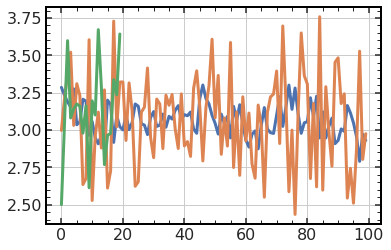

In [16]:
print("SPLITS: ",kfs_mspe_data_t1.num_splits)
print("SPLITS: ",kfs_mspe_data_t1.num_folds)
print("TRAIN: ",kfs_mspe_data_t1.num_train_pts)
print("VAL: ",kfs_mspe_data_t1.num_val_pts)
print("TEST: ",kfs_mspe_data_t1.num_test_pts)
print("INTERP: ",kfs_mspe_data_t1.num_interp_pts)
tmparr = [] ; tmparr2 = [] ; tmparr3 = []
for i in range(kfs_mspe_data_t1.num_splits):
    tmparr3.append(np.mean(kfs_mspe_data_t1.Y_test_list[i][:]))
    for j in range(kfs_mspe_data_t1.num_folds):
        # print("MEAN visc: {:.2f} ".format(np.mean(kfs_data_t1.Y_train_dbllist[i][j][:])))
        tmparr.append(np.mean(kfs_mspe_data_t1.Y_train_dbllist[i][j][:]))
        tmparr2.append(np.mean(kfs_mspe_data_t1.Y_val_dbllist[i][j][:]))
        
plt.plot(tmparr)        
plt.plot(tmparr2) 
plt.plot(tmparr3) 

## Model classes

### Kfold models for mspe -- kfold_split_mspe_models()

In [17]:
# the idea is to use it once for model selection (by saving models to trained_model_dbllist)
# then at the selected hyperparameter train the models on the whole fit data set (save the models to fit_model_list)
class kfold_split_mspe_models:
    def __init__(self):
        self.num_splits = 0
        self.num_folds = 0
        
        ## Lists to store the models and their predictions
        self.trained_model_dbllist = []
        self.fit_model_list = []
        self.best_hyperparameter_dict = {}
        
    def predict(self,kfs_mspe_data,ft_indx):
        self.num_train_pts = kfs_mspe_data.num_train_pts
        self.num_val_pts = kfs_mspe_data.num_val_pts
        self.num_test_pts = kfs_mspe_data.num_test_pts
        self.num_interp_pts = kfs_mspe_data.num_interp_pts
        self.num_fit_pts = kfs_mspe_data.num_fit_pts
        self.ft_indx = ft_indx

        ## Lists to store the predicted values
        ## Yerr_pred exist only for ANN
        self.Y_pred_train_dbllist = [] ; self.Yerr_pred_train_dbllist = []
        self.Y_pred_val_dbllist = [] ; self.Yerr_pred_val_dbllist = []
        self.Y_pred_test_dbllist = [] ; self.Yerr_pred_test_dbllist = []
        self.Y_pred_interp_dbllist = [] ; self.Yerr_pred_interp_dbllist = []
        

        for i in range(self.num_splits):
            tmparr1 = [] ; tmparr2 = [] ; tmparr3 = [] ; tmparr4 = []
            for j in range(self.num_folds):
                # Train pred
                tmparr1.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_train_dbllist[i][j][:,ft_indx])))
                # Val pred
                tmparr2.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_val_dbllist[i][j][:,ft_indx])))
                # Test pred
                tmparr3.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_test_list[i][:,ft_indx])))
                # Interp pred
                tmparr4.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_interp_list[i][:,ft_indx])))
            
            ## store the predictions
            self.Y_pred_train_dbllist.append(tmparr1)
            self.Y_pred_val_dbllist.append(tmparr2)
            self.Y_pred_test_dbllist.append(tmparr3)
            self.Y_pred_interp_dbllist.append(tmparr4)

    def predict_for_performance_evaluation(self,kfs_mspe_data,ft_indx):
        ## Lists to store the predicted values for performance evaluation
        ## ideally to be evaluated at optimized hyperparameter values (though this class doesn't care)
        ## Yerr_pred exist only for ANN
        self.Y_pred_pe_fit_list = [] ; self.Yerr_pred_pe_fit_list = []
        self.Y_pred_pe_test_list = [] ; self.Yerr_pred_pe_test_list = []
        self.Y_pred_pe_interp_list = [] ; self.Yerr_pred_pe_interp_list = []
        
        for i in range(self.num_splits):
            # Train pred
            tmparr1 = np.power(10,self.fit_model_list[i].predict(
                    kfs_mspe_data.X_fit_list[i][:,ft_indx]))
            # Test pred
            tmparr3 = np.power(10,self.fit_model_list[i].predict(
                    kfs_mspe_data.X_test_list[i][:,ft_indx]))
            # Interp pred
            tmparr4 = np.power(10,self.fit_model_list[i].predict(
                    kfs_mspe_data.X_interp_list[i][:,ft_indx]))
            
            ## store the predictions
            self.Y_pred_pe_fit_list.append(tmparr1)
            self.Y_pred_pe_test_list.append(tmparr3)
            self.Y_pred_pe_interp_list.append(tmparr4)

## Metric classes

### metric class to store the final results in one place -- metric_obj()

In [18]:
class metric_obj:
    def __init__(self):
        self.val_MSE_avg = 0
        self.val_MAE_avg = 0
        self.val_MAPE_avg = 0
        self.val_R2_avg = 0
        self.val_ME_avg = 0
        self.val_MPE_avg = 0
        self.val_MSE_std = 0
        self.val_MAE_std = 0
        self.val_MAPE_std = 0
        self.val_R2_std = 0
        self.val_ME_std = 0
        self.val_MPE_std = 0

        self.test_MSE_avg = 0
        self.test_MAE_avg = 0
        self.test_MAPE_avg = 0
        self.test_R2_avg = 0
        self.test_ME_avg = 0
        self.test_MPE_avg = 0
        self.test_MSE_std = 0
        self.test_MAE_std = 0
        self.test_MAPE_std = 0
        self.test_R2_std = 0
        self.test_ME_std = 0
        self.test_MPE_std = 0

        self.interp_MSE_avg = 0
        self.interp_MAE_avg = 0
        self.interp_MAPE_avg = 0
        self.interp_R2_avg = 0
        self.interp_ME_avg = 0
        self.interp_MPE_avg = 0
        self.interp_MSE_std = 0
        self.interp_MAE_std = 0
        self.interp_MAPE_std = 0
        self.interp_R2_std = 0
        self.interp_ME_std = 0
        self.interp_MPE_std = 0

        self.train_MSE_avg = 0
        self.train_MAE_avg = 0
        self.train_MAPE_avg = 0
        self.train_R2_avg = 0
        self.train_ME_avg = 0
        self.train_MPE_avg = 0
        self.train_MSE_std = 0
        self.train_MAE_std = 0
        self.train_MAPE_std = 0
        self.train_R2_std = 0
        self.train_ME_std = 0
        self.train_MPE_std = 0

        ## quantile
        self.val_MSE_median = 0
        self.val_MAE_median = 0
        self.val_MAPE_median = 0
        self.val_R2_median = 0
        self.val_ME_median = 0
        self.val_MPE_median = 0
        self.val_MSE_q2p5 = 0 ; self.val_MSE_q97p5 = 0
        self.val_MAE_q2p5 = 0 ; self.val_MAE_q97p5 = 0
        self.val_MAPE_q2p5 = 0 ; self.val_MAPE_q97p5 = 0
        self.val_R2_q2p5 = 0 ; self.val_R2_q97p5 = 0
        self.val_ME_q2p5 = 0 ; self.val_ME_q97p5 = 0
        self.val_MPE_q2p5 = 0 ; self.val_MPE_q97p5 = 0

        self.test_MSE_median = 0
        self.test_MAE_median = 0
        self.test_MAPE_median = 0
        self.test_R2_median = 0
        self.test_ME_median = 0
        self.test_MPE_median = 0
        self.test_MSE_q2p5 = 0 ; self.test_MSE_q97p5 = 0
        self.test_MAE_q2p5 = 0 ; self.test_MAE_q97p5 = 0
        self.test_MAPE_q2p5 = 0 ; self.test_MAPE_q97p5 = 0
        self.test_R2_q2p5 = 0 ; self.test_R2_q97p5 = 0
        self.test_ME_q2p5 = 0 ; self.test_ME_q97p5 = 0
        self.test_MPE_q2p5 = 0 ; self.test_MPE_q97p5 = 0

        self.interp_MSE_median = 0
        self.interp_MAE_median = 0
        self.interp_MAPE_median = 0
        self.interp_R2_median = 0
        self.interp_ME_median = 0
        self.interp_MPE_median = 0
        self.interp_MSE_q2p5 = 0 ; self.interp_MSE_q97p5 = 0
        self.interp_MAE_q2p5 = 0 ; self.interp_MAE_q97p5 = 0
        self.interp_MAPE_q2p5 = 0 ; self.interp_MAPE_q97p5 = 0
        self.interp_R2_q2p5 = 0 ; self.interp_R2_q97p5 = 0
        self.interp_ME_q2p5 = 0 ; self.interp_ME_q97p5 = 0
        self.interp_MPE_q2p5 = 0 ; self.interp_MPE_q97p5 = 0

        self.train_MSE_median = 0
        self.train_MAE_median = 0
        self.train_MAPE_median = 0
        self.train_R2_median = 0
        self.train_ME_median = 0
        self.train_MPE_median = 0
        self.train_MSE_q2p5 = 0 ; self.train_MSE_q97p5 = 0
        self.train_MAE_q2p5 = 0 ; self.train_MAE_q97p5 = 0
        self.train_MAPE_q2p5 = 0 ; self.train_MAPE_q97p5 = 0
        self.train_R2_q2p5 = 0 ; self.train_R2_q97p5 = 0
        self.train_ME_q2p5 = 0 ; self.train_ME_q97p5 = 0
        self.train_MPE_q2p5 = 0 ; self.train_MPE_q97p5 = 0
        
        self.ndx = 0

### metric class for mspe -- kfs_mspe_metrics()

In [19]:
class kfs_mspe_metrics:
    def __init__(self):
        self.num_splits = 0
        self.num_folds = 0

    def est_errors(self,kfs_mspe_data,kfs_mspe_models):
        self.num_splits = kfs_mspe_data.num_splits
        self.num_folds = kfs_mspe_data.num_folds
        self.num_train_pts = kfs_mspe_data.num_train_pts
        self.num_val_pts = kfs_mspe_data.num_val_pts
        self.num_test_pts = kfs_mspe_data.num_test_pts
        self.num_interp_pts = kfs_mspe_data.num_interp_pts
        self.num_fit_pts = kfs_mspe_data.num_fit_pts
        self.ft_indx = kfs_mspe_models.ft_indx

        ## Lists to store the model fold+split errors
        self.MSE_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAE_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAPE_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.R2_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.ME_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MPE_train_split_fold = np.zeros((self.num_splits,self.num_folds))

        self.MSE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAPE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.R2_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.ME_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MPE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 

        self.MSE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAPE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.R2_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.ME_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MPE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 

        self.MSE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAPE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.R2_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.ME_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MPE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))

        for i in range(self.num_splits):
            for j in range(self.num_folds):
                # Train errors
                self.MSE_train_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                self.MAE_train_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                self.MAPE_train_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                self.R2_train_split_fold[i,j] = r2_score(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_train_dbllist[i][j]-kfs_mspe_data.Y_train_dbllist[i][j]
                self.ME_train_split_fold[i,j] = np.mean(tmparr)
                self.MPE_train_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_train_dbllist[i][j])

                # Val errors
                self.MSE_val_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                self.MAE_val_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                self.MAPE_val_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                self.R2_val_split_fold[i,j] = r2_score(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_val_dbllist[i][j]-kfs_mspe_data.Y_val_dbllist[i][j]
                self.ME_val_split_fold[i,j] = np.mean(tmparr)
                self.MPE_val_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_val_dbllist[i][j])

                # Test errors
                self.MSE_test_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                self.MAE_test_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                self.MAPE_test_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                self.R2_test_split_fold[i,j] = r2_score(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_test_dbllist[i][j]-kfs_mspe_data.Y_test_list[i]
                self.ME_test_split_fold[i,j] = np.mean(tmparr)
                self.MPE_test_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_test_list[i])

                # Interp errors
                self.MSE_interp_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                self.MAE_interp_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                self.MAPE_interp_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                self.R2_interp_split_fold[i,j] = r2_score(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_interp_dbllist[i][j]-kfs_mspe_data.Y_interp_list[i]
                self.ME_interp_split_fold[i,j] = np.mean(tmparr)
                self.MPE_interp_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_interp_list[i])
        
        # Now evaluate the statistics on the above metrics
        self._stat_errors()

    def est_errors_for_performance_evaluation(self,kfs_mspe_data,kfs_mspe_models):
        # Note that the model object's fit_model_list[] has to be populated before this function is called
        self.best_hyperparameter_dict = kfs_mspe_models.best_hyperparameter_dict

        ## Lists to store the model fold+split errors
        self.MSE_mspe_fit_split = np.zeros(self.num_splits)
        self.MAE_mspe_fit_split = np.zeros(self.num_splits)
        self.MAPE_mspe_fit_split = np.zeros(self.num_splits)
        self.R2_mspe_fit_split = np.zeros(self.num_splits)
        self.ME_mspe_fit_split = np.zeros(self.num_splits)
        self.MPE_mspe_fit_split = np.zeros(self.num_splits)

        self.MSE_mspe_test_split = np.zeros(self.num_splits)
        self.MAE_mspe_test_split = np.zeros(self.num_splits)
        self.MAPE_mspe_test_split = np.zeros(self.num_splits)
        self.R2_mspe_test_split = np.zeros(self.num_splits)
        self.ME_mspe_test_split = np.zeros(self.num_splits)
        self.MPE_mspe_test_split = np.zeros(self.num_splits)

        self.MSE_mspe_interp_split = np.zeros(self.num_splits)
        self.MAE_mspe_interp_split = np.zeros(self.num_splits)
        self.MAPE_mspe_interp_split = np.zeros(self.num_splits)
        self.R2_mspe_interp_split = np.zeros(self.num_splits)
        self.ME_mspe_interp_split = np.zeros(self.num_splits)
        self.MPE_mspe_interp_split = np.zeros(self.num_splits)

        for i in range(self.num_splits):
            # Train errors
            self.MSE_mspe_fit_split[i] = mean_squared_error(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            self.MAE_mspe_fit_split[i] = mean_absolute_error(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            self.MAPE_mspe_fit_split[i] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            self.R2_mspe_fit_split[i] = r2_score(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            tmparr = kfs_mspe_models.Y_pred_pe_fit_list[i]-kfs_mspe_data.Y_fit_list[i]
            self.ME_mspe_fit_split[i] = np.mean(tmparr)
            self.MPE_mspe_fit_split[i] = 100*np.mean((tmparr)/kfs_mspe_data.Y_fit_list[i])

            # Test errors
            self.MSE_mspe_test_split[i] = mean_squared_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            self.MAE_mspe_test_split[i] = mean_absolute_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            self.MAPE_mspe_test_split[i] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            self.R2_mspe_test_split[i] = r2_score(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            tmparr = kfs_mspe_models.Y_pred_pe_test_list[i]-kfs_mspe_data.Y_test_list[i]
            self.ME_mspe_test_split[i] = np.mean(tmparr)
            self.MPE_mspe_test_split[i] = 100*np.mean((tmparr)/kfs_mspe_data.Y_test_list[i])

            # Interp errors
            self.MSE_mspe_interp_split[i] = mean_squared_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            self.MAE_mspe_interp_split[i] = mean_absolute_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            self.MAPE_mspe_interp_split[i] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            self.R2_mspe_interp_split[i] = r2_score(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            tmparr = kfs_mspe_models.Y_pred_pe_interp_list[i]-kfs_mspe_data.Y_interp_list[i]
            self.ME_mspe_interp_split[i] = np.mean(tmparr)
            self.MPE_mspe_interp_split[i] = 100*np.mean((tmparr)/kfs_mspe_data.Y_interp_list[i])

        ## Lists to store the mean model errors
        self.MSE_mspe_fit_avg = np.mean(self.MSE_mspe_fit_split) ; self.MSE_mspe_fit_std = np.std(self.MSE_mspe_fit_split)
        self.MAE_mspe_fit_avg = np.mean(self.MAE_mspe_fit_split) ; self.MAE_mspe_fit_std = np.std(self.MAE_mspe_fit_split)
        self.MAPE_mspe_fit_avg = np.mean(self.MAPE_mspe_fit_split) ; self.MAPE_mspe_fit_std = np.std(self.MAPE_mspe_fit_split)
        self.R2_mspe_fit_avg = np.mean(self.R2_mspe_fit_split) ; self.R2_mspe_fit_std = np.std(self.R2_mspe_fit_split)
        self.ME_mspe_fit_avg = np.mean(self.ME_mspe_fit_split) ; self.ME_mspe_fit_std = np.std(self.ME_mspe_fit_split)
        self.MPE_mspe_fit_avg = np.mean(self.MPE_mspe_fit_split) ; self.MPE_mspe_fit_std = np.std(self.MPE_mspe_fit_split)

        self.MSE_mspe_test_avg = np.mean(self.MSE_mspe_test_split) ; self.MSE_mspe_test_std = np.std(self.MSE_mspe_test_split)
        self.MAE_mspe_test_avg = np.mean(self.MAE_mspe_test_split) ; self.MAE_mspe_test_std = np.std(self.MAE_mspe_test_split)
        self.MAPE_mspe_test_avg = np.mean(self.MAPE_mspe_test_split) ; self.MAPE_mspe_test_std = np.std(self.MAPE_mspe_test_split)
        self.R2_mspe_test_avg = np.mean(self.R2_mspe_test_split) ; self.R2_mspe_test_std = np.std(self.R2_mspe_test_split)
        self.ME_mspe_test_avg = np.mean(self.ME_mspe_test_split) ; self.ME_mspe_test_std = np.std(self.ME_mspe_test_split)
        self.MPE_mspe_test_avg = np.mean(self.MPE_mspe_test_split) ; self.MPE_mspe_test_std = np.std(self.MPE_mspe_test_split)
        
        self.MSE_mspe_interp_avg = np.mean(self.MSE_mspe_interp_split) ; self.MSE_mspe_interp_std = np.std(self.MSE_mspe_interp_split)
        self.MAE_mspe_interp_avg = np.mean(self.MAE_mspe_interp_split) ; self.MAE_mspe_interp_std = np.std(self.MAE_mspe_interp_split)
        self.MAPE_mspe_interp_avg = np.mean(self.MAPE_mspe_interp_split) ; self.MAPE_mspe_interp_std = np.std(self.MAPE_mspe_interp_split)
        self.R2_mspe_interp_avg = np.mean(self.R2_mspe_interp_split) ; self.R2_mspe_interp_std = np.std(self.R2_mspe_interp_split)
        self.ME_mspe_interp_avg = np.mean(self.ME_mspe_interp_split) ; self.ME_mspe_interp_std = np.std(self.ME_mspe_interp_split)
        self.MPE_mspe_interp_avg = np.mean(self.MPE_mspe_interp_split) ; self.MPE_mspe_interp_std = np.std(self.MPE_mspe_interp_split)

        ## Lists to store the mean model errors
        self.MSE_mspe_fit_median = np.median(self.MSE_mspe_fit_split) ; self.MSE_mspe_fit_q2p5 = np.percentile(self.MSE_mspe_fit_split,2.5) ; self.MSE_mspe_fit_q97p5 = np.percentile(self.MSE_mspe_fit_split,97.5)
        self.MAE_mspe_fit_median = np.median(self.MAE_mspe_fit_split) ; self.MAE_mspe_fit_q2p5 = np.percentile(self.MAE_mspe_fit_split,2.5) ; self.MAE_mspe_fit_q97p5 = np.percentile(self.MAE_mspe_fit_split,97.5)
        self.MAPE_mspe_fit_median = np.median(self.MAPE_mspe_fit_split) ; self.MAPE_mspe_fit_q2p5 = np.percentile(self.MAPE_mspe_fit_split,2.5) ; self.MAPE_mspe_fit_q97p5 = np.percentile(self.MAPE_mspe_fit_split,97.5)
        self.R2_mspe_fit_median = np.median(self.R2_mspe_fit_split) ; self.R2_mspe_fit_q2p5 = np.percentile(self.R2_mspe_fit_split,2.5) ; self.R2_mspe_fit_q97p5 = np.percentile(self.R2_mspe_fit_split,97.5)
        self.ME_mspe_fit_median = np.median(self.ME_mspe_fit_split) ; self.ME_mspe_fit_q2p5 = np.percentile(self.ME_mspe_fit_split,2.5) ; self.ME_mspe_fit_q97p5 = np.percentile(self.ME_mspe_fit_split,97.5)
        self.MPE_mspe_fit_median = np.median(self.MPE_mspe_fit_split) ; self.MPE_mspe_fit_q2p5 = np.percentile(self.MPE_mspe_fit_split,2.5) ; self.MPE_mspe_fit_q97p5 = np.percentile(self.MPE_mspe_fit_split,97.5)

        self.MSE_mspe_test_median = np.median(self.MSE_mspe_test_split) ; self.MSE_mspe_test_q2p5 = np.percentile(self.MSE_mspe_test_split,2.5) ; self.MSE_mspe_test_q97p5 = np.percentile(self.MSE_mspe_test_split,97.5)
        self.MAE_mspe_test_median = np.median(self.MAE_mspe_test_split) ; self.MAE_mspe_test_q2p5 = np.percentile(self.MAE_mspe_test_split,2.5) ; self.MAE_mspe_test_q97p5 = np.percentile(self.MAE_mspe_test_split,97.5)
        self.MAPE_mspe_test_median = np.median(self.MAPE_mspe_test_split) ; self.MAPE_mspe_test_q2p5 = np.percentile(self.MAPE_mspe_test_split,2.5) ; self.MAPE_mspe_test_q97p5 = np.percentile(self.MAPE_mspe_test_split,97.5)
        self.R2_mspe_test_median = np.median(self.R2_mspe_test_split) ; self.R2_mspe_test_q2p5 = np.percentile(self.R2_mspe_test_split,2.5) ; self.R2_mspe_test_q97p5 = np.percentile(self.R2_mspe_test_split,97.5)
        self.ME_mspe_test_median = np.median(self.ME_mspe_test_split) ; self.ME_mspe_test_q2p5 = np.percentile(self.ME_mspe_test_split,2.5) ; self.ME_mspe_test_q97p5 = np.percentile(self.ME_mspe_test_split,97.5)
        self.MPE_mspe_test_median = np.median(self.MPE_mspe_test_split) ; self.MPE_mspe_test_q2p5 = np.percentile(self.MPE_mspe_test_split,2.5) ; self.MPE_mspe_test_q97p5 = np.percentile(self.MPE_mspe_test_split,97.5)
        
        self.MSE_mspe_interp_median = np.median(self.MSE_mspe_interp_split) ; self.MSE_mspe_interp_q2p5 = np.percentile(self.MSE_mspe_interp_split,2.5) ; self.MSE_mspe_interp_q97p5 = np.percentile(self.MSE_mspe_interp_split,97.5)
        self.MAE_mspe_interp_median = np.median(self.MAE_mspe_interp_split) ; self.MAE_mspe_interp_q2p5 = np.percentile(self.MAE_mspe_interp_split,2.5) ; self.MAE_mspe_interp_q97p5 = np.percentile(self.MAE_mspe_interp_split,97.5)
        self.MAPE_mspe_interp_median = np.median(self.MAPE_mspe_interp_split) ; self.MAPE_mspe_interp_q2p5 = np.percentile(self.MAPE_mspe_interp_split,2.5) ; self.MAPE_mspe_interp_q97p5 = np.percentile(self.MAPE_mspe_interp_split,97.5)
        self.R2_mspe_interp_median = np.median(self.R2_mspe_interp_split) ; self.R2_mspe_interp_q2p5 = np.percentile(self.R2_mspe_interp_split,2.5) ; self.R2_mspe_interp_q97p5 = np.percentile(self.R2_mspe_interp_split,97.5)
        self.ME_mspe_interp_median = np.median(self.ME_mspe_interp_split) ; self.ME_mspe_interp_q2p5 = np.percentile(self.ME_mspe_interp_split,2.5) ; self.ME_mspe_interp_q97p5 = np.percentile(self.ME_mspe_interp_split,97.5)
        self.MPE_mspe_interp_median = np.median(self.MPE_mspe_interp_split) ; self.MPE_mspe_interp_q2p5 = np.percentile(self.MPE_mspe_interp_split,2.5) ; self.MPE_mspe_interp_q97p5 = np.percentile(self.MPE_mspe_interp_split,97.5)
            
    def _stat_errors(self):

        ## Lists to store the model split errors
        self.MSE_train_split = np.zeros(self.num_splits)
        self.MAE_train_split = np.zeros(self.num_splits)
        self.MAPE_train_split = np.zeros(self.num_splits)
        self.R2_train_split = np.zeros(self.num_splits)
        self.ME_train_split = np.zeros(self.num_splits)
        self.MPE_train_split = np.zeros(self.num_splits)

        self.MSE_val_split = np.zeros(self.num_splits) 
        self.MAE_val_split = np.zeros(self.num_splits) 
        self.MAPE_val_split = np.zeros(self.num_splits) 
        self.R2_val_split = np.zeros(self.num_splits) 
        self.ME_val_split = np.zeros(self.num_splits) 
        self.MPE_val_split = np.zeros(self.num_splits) 

        self.MSE_test_split = np.zeros(self.num_splits) 
        self.MAE_test_split = np.zeros(self.num_splits) 
        self.MAPE_test_split = np.zeros(self.num_splits) 
        self.R2_test_split = np.zeros(self.num_splits) 
        self.ME_test_split = np.zeros(self.num_splits) 
        self.MPE_test_split = np.zeros(self.num_splits) 

        self.MSE_interp_split = np.zeros(self.num_splits)
        self.MAE_interp_split = np.zeros(self.num_splits)
        self.MAPE_interp_split = np.zeros(self.num_splits)
        self.R2_interp_split = np.zeros(self.num_splits)
        self.ME_interp_split = np.zeros(self.num_splits)
        self.MPE_interp_split = np.zeros(self.num_splits)

        # Estimate the mean over the folds
        for i in range(self.num_splits):
            self.MSE_train_split[i] = np.mean(self.MSE_train_split_fold[i,:])
            self.MAE_train_split[i] = np.mean(self.MAE_train_split_fold[i,:])
            self.MAPE_train_split[i] = np.mean(self.MAPE_train_split_fold[i,:])
            self.R2_train_split[i] = np.mean(self.R2_train_split_fold[i,:])
            self.ME_train_split[i] = np.mean(self.ME_train_split_fold[i,:])
            self.MPE_train_split[i] = np.mean(self.MPE_train_split_fold[i,:])

            self.MSE_val_split[i] = np.mean(self.MSE_val_split_fold[i,:]) 
            self.MAE_val_split[i] = np.mean(self.MAE_val_split_fold[i,:]) 
            self.MAPE_val_split[i] = np.mean(self.MAPE_val_split_fold[i,:]) 
            self.R2_val_split[i] = np.mean(self.R2_val_split_fold[i,:]) 
            self.ME_val_split[i] = np.mean(self.ME_val_split_fold[i,:]) 
            self.MPE_val_split[i] = np.mean(self.MPE_val_split_fold[i,:]) 

            self.MSE_test_split[i] = np.mean(self.MSE_test_split_fold[i,:]) 
            self.MAE_test_split[i] = np.mean(self.MAE_test_split_fold[i,:]) 
            self.MAPE_test_split[i] = np.mean(self.MAPE_test_split_fold[i,:]) 
            self.R2_test_split[i] = np.mean(self.R2_test_split_fold[i,:]) 
            self.ME_test_split[i] = np.mean(self.ME_test_split_fold[i,:]) 
            self.MPE_test_split[i] = np.mean(self.MPE_test_split_fold[i,:]) 

            self.MSE_interp_split[i] = np.mean(self.MSE_interp_split_fold[i,:])
            self.MAE_interp_split[i] = np.mean(self.MAE_interp_split_fold[i,:])
            self.MAPE_interp_split[i] = np.mean(self.MAPE_interp_split_fold[i,:])
            self.R2_interp_split[i] = np.mean(self.R2_interp_split_fold[i,:])
            self.ME_interp_split[i] = np.mean(self.ME_interp_split_fold[i,:])
            self.MPE_interp_split[i] = np.mean(self.MPE_interp_split_fold[i,:])


        ## Lists to store the mean model errors
        self.MSE_train_avg = np.mean(self.MSE_train_split) ; self.MSE_train_std = np.std(self.MSE_train_split)
        self.MAE_train_avg = np.mean(self.MAE_train_split) ; self.MAE_train_std = np.std(self.MAE_train_split)
        self.MAPE_train_avg = np.mean(self.MAPE_train_split) ; self.MAPE_train_std = np.std(self.MAPE_train_split)
        self.R2_train_avg = np.mean(self.R2_train_split) ; self.R2_train_std = np.std(self.R2_train_split)
        self.ME_train_avg = np.mean(self.ME_train_split) ; self.ME_train_std = np.std(self.ME_train_split)
        self.MPE_train_avg = np.mean(self.MPE_train_split) ; self.MPE_train_std = np.std(self.MPE_train_split)

        self.MSE_val_avg = np.mean(self.MSE_val_split) ; self.MSE_val_std = np.std(self.MSE_val_split) 
        self.MAE_val_avg = np.mean(self.MAE_val_split) ; self.MAE_val_std = np.std(self.MAE_val_split) 
        self.MAPE_val_avg = np.mean(self.MAPE_val_split) ; self.MAPE_val_std = np.std(self.MAPE_val_split) 
        self.R2_val_avg = np.mean(self.R2_val_split) ; self.R2_val_std = np.std(self.R2_val_split) 
        self.ME_val_avg = np.mean(self.ME_val_split) ; self.ME_val_std = np.std(self.ME_val_split) 
        self.MPE_val_avg = np.mean(self.MPE_val_split) ; self.MPE_val_std = np.std(self.MPE_val_split) 

        self.MSE_test_avg = np.mean(self.MSE_test_split) ; self.MSE_test_std = np.std(self.MSE_test_split)
        self.MAE_test_avg = np.mean(self.MAE_test_split) ; self.MAE_test_std = np.std(self.MAE_test_split)
        self.MAPE_test_avg = np.mean(self.MAPE_test_split) ; self.MAPE_test_std = np.std(self.MAPE_test_split)
        self.R2_test_avg = np.mean(self.R2_test_split) ; self.R2_test_std = np.std(self.R2_test_split)
        self.ME_test_avg = np.mean(self.ME_test_split) ; self.ME_test_std = np.std(self.ME_test_split)
        self.MPE_test_avg = np.mean(self.MPE_test_split) ; self.MPE_test_std = np.std(self.MPE_test_split)
        
        self.MSE_interp_avg = np.mean(self.MSE_interp_split) ; self.MSE_interp_std = np.std(self.MSE_interp_split)
        self.MAE_interp_avg = np.mean(self.MAE_interp_split) ; self.MAE_interp_std = np.std(self.MAE_interp_split)
        self.MAPE_interp_avg = np.mean(self.MAPE_interp_split) ; self.MAPE_interp_std = np.std(self.MAPE_interp_split)
        self.R2_interp_avg = np.mean(self.R2_interp_split) ; self.R2_interp_std = np.std(self.R2_interp_split)
        self.ME_interp_avg = np.mean(self.ME_interp_split) ; self.ME_interp_std = np.std(self.ME_interp_split)
        self.MPE_interp_avg = np.mean(self.MPE_interp_split) ; self.MPE_interp_std = np.std(self.MPE_interp_split)

        ## Lists to store the quantile model errors
        self.MSE_train_median = np.median(self.MSE_train_split) ; self.MSE_train_q2p5 = np.percentile(self.MSE_train_split,2.5) ; self.MSE_train_q97p5 = np.percentile(self.MSE_train_split,97.5)
        self.MAE_train_median = np.median(self.MAE_train_split) ; self.MAE_train_q2p5 = np.percentile(self.MAE_train_split,2.5) ; self.MAE_train_q97p5 = np.percentile(self.MAE_train_split,97.5)
        self.MAPE_train_median = np.median(self.MAPE_train_split) ; self.MAPE_train_q2p5 = np.percentile(self.MAPE_train_split,2.5) ; self.MAPE_train_q97p5 = np.percentile(self.MAPE_train_split,97.5)
        self.R2_train_median = np.median(self.R2_train_split) ; self.R2_train_q2p5 = np.percentile(self.R2_train_split,2.5) ; self.R2_train_q97p5 = np.percentile(self.R2_train_split,97.5)
        self.ME_train_median = np.median(self.ME_train_split) ; self.ME_train_q2p5 = np.percentile(self.ME_train_split,2.5) ; self.ME_train_q97p5 = np.percentile(self.ME_train_split,97.5)
        self.MPE_train_median = np.median(self.MPE_train_split) ; self.MPE_train_q2p5 = np.percentile(self.MPE_train_split,2.5) ; self.MPE_train_q97p5 = np.percentile(self.MPE_train_split,97.5)

        self.MSE_val_median = np.median(self.MSE_val_split) ; self.MSE_val_q2p5 = np.percentile(self.MSE_val_split,2.5)  ; self.MSE_val_q97p5 = np.percentile(self.MSE_val_split,97.5) 
        self.MAE_val_median = np.median(self.MAE_val_split) ; self.MAE_val_q2p5 = np.percentile(self.MAE_val_split,2.5)  ; self.MAE_val_q97p5 = np.percentile(self.MAE_val_split,97.5) 
        self.MAPE_val_median = np.median(self.MAPE_val_split) ; self.MAPE_val_q2p5 = np.percentile(self.MAPE_val_split,2.5)  ; self.MAPE_val_q97p5 = np.percentile(self.MAPE_val_split,97.5) 
        self.R2_val_median = np.median(self.R2_val_split) ; self.R2_val_q2p5 = np.percentile(self.R2_val_split,2.5)  ; self.R2_val_q97p5 = np.percentile(self.R2_val_split,97.5) 
        self.ME_val_median = np.median(self.ME_val_split) ; self.ME_val_q2p5 = np.percentile(self.ME_val_split,2.5)  ; self.ME_val_q97p5 = np.percentile(self.ME_val_split,97.5) 
        self.MPE_val_median = np.median(self.MPE_val_split) ; self.MPE_val_q2p5 = np.percentile(self.MPE_val_split,2.5)  ; self.MPE_val_q97p5 = np.percentile(self.MPE_val_split,97.5) 

        self.MSE_test_median = np.median(self.MSE_test_split) ; self.MSE_test_q2p5 = np.percentile(self.MSE_test_split,2.5) ; self.MSE_test_q97p5 = np.percentile(self.MSE_test_split,97.5)
        self.MAE_test_median = np.median(self.MAE_test_split) ; self.MAE_test_q2p5 = np.percentile(self.MAE_test_split,2.5) ; self.MAE_test_q97p5 = np.percentile(self.MAE_test_split,97.5)
        self.MAPE_test_median = np.median(self.MAPE_test_split) ; self.MAPE_test_q2p5 = np.percentile(self.MAPE_test_split,2.5) ; self.MAPE_test_q97p5 = np.percentile(self.MAPE_test_split,97.5)
        self.R2_test_median = np.median(self.R2_test_split) ; self.R2_test_q2p5 = np.percentile(self.R2_test_split,2.5) ; self.R2_test_q97p5 = np.percentile(self.R2_test_split,97.5)
        self.ME_test_median = np.median(self.ME_test_split) ; self.ME_test_q2p5 = np.percentile(self.ME_test_split,2.5) ; self.ME_test_q97p5 = np.percentile(self.ME_test_split,97.5)
        self.MPE_test_median = np.median(self.MPE_test_split) ; self.MPE_test_q2p5 = np.percentile(self.MPE_test_split,2.5) ; self.MPE_test_q97p5 = np.percentile(self.MPE_test_split,97.5)
        
        self.MSE_interp_median = np.median(self.MSE_interp_split) ; self.MSE_interp_q2p5 = np.percentile(self.MSE_interp_split,2.5) ; self.MSE_interp_q97p5 = np.percentile(self.MSE_interp_split,97.5)
        self.MAE_interp_median = np.median(self.MAE_interp_split) ; self.MAE_interp_q2p5 = np.percentile(self.MAE_interp_split,2.5) ; self.MAE_interp_q97p5 = np.percentile(self.MAE_interp_split,97.5)
        self.MAPE_interp_median = np.median(self.MAPE_interp_split) ; self.MAPE_interp_q2p5 = np.percentile(self.MAPE_interp_split,2.5) ; self.MAPE_interp_q97p5 = np.percentile(self.MAPE_interp_split,97.5)
        self.R2_interp_median = np.median(self.R2_interp_split) ; self.R2_interp_q2p5 = np.percentile(self.R2_interp_split,2.5) ; self.R2_interp_q97p5 = np.percentile(self.R2_interp_split,97.5)
        self.ME_interp_median = np.median(self.ME_interp_split) ; self.ME_interp_q2p5 = np.percentile(self.ME_interp_split,2.5) ; self.ME_interp_q97p5 = np.percentile(self.ME_interp_split,97.5)
        self.MPE_interp_median = np.median(self.MPE_interp_split) ; self.MPE_interp_q2p5 = np.percentile(self.MPE_interp_split,2.5) ; self.MPE_interp_q97p5 = np.percentile(self.MPE_interp_split,97.5)

# Load the saved postMD ANN models

## Load

In [24]:
loadpath = "1-test-single-ANN/saved-models/"

ft_indx = [0,1,2,3,4,5]
ANN_kfs_postMD_t1 = kfold_split_mspe_models() 
ANN_kfs_postMD_t1.num_splits = kfs_mspe_data_t1.num_splits
ANN_kfs_postMD_t1.num_folds = kfs_mspe_data_t1.num_folds

tic = time.perf_counter() 
# Loop over splits
for j in range(kfs_mspe_data_t1.num_splits):
    tmparr = [] 
    # Loop over k-folds
    for k in range(kfs_mspe_data_t1.num_folds):

        # Load the trained model with the particular train split and hyperparameter
        ANNmdl = load_model(loadpath+'ANN_postMD_{}_{}.h5'.format(j,k))
        tmparr.append(ANNmdl) 
    
    # store the k-trained models
    ANN_kfs_postMD_t1.trained_model_dbllist.append(tmparr)

    if(np.mod(j,2)==0):
        print("{:.0f}%".format(100*j/kfs_mspe_data_t1.num_splits))
        # ANNmdl.summary()

# Predict on val, test and interp sets
ANN_kfs_postMD_t1.predict(kfs_mspe_data_t1,ft_indx)

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Time taken: 1 min


In [25]:
tic = time.perf_counter() 

## Create the metrics object
ANN_kfs_metrics_postMD_t1 = kfs_mspe_metrics()

## Estimate the errors and the corresponding statistics
ANN_kfs_metrics_postMD_t1.est_errors(kfs_mspe_data_t1,ANN_kfs_postMD_t1)

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))        

Time taken: 0 min


## Print the summary

In [26]:
print("---------------------------------------------------------------------------------------")
print("------------------------------ AVG VALIDATION LANDSCAPE -------------------------------")
print("---------------------------------------------------------------------------------------")
print()

print("***************************************************************************************")
print("CRITERION: MIN VAL MSE --> {:.3e} ({:.0e}) ".format(ANN_kfs_metrics_postMD_t1.MSE_val_avg,
    2*ANN_kfs_metrics_postMD_t1.MSE_val_std))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(ANN_kfs_metrics_postMD_t1.MSE_train_avg,2*ANN_kfs_metrics_postMD_t1.MSE_train_std,
              ANN_kfs_metrics_postMD_t1.MSE_val_avg,2*ANN_kfs_metrics_postMD_t1.MSE_val_std,
              ANN_kfs_metrics_postMD_t1.MSE_test_avg,2*ANN_kfs_metrics_postMD_t1.MSE_test_std,
              ANN_kfs_metrics_postMD_t1.MSE_interp_avg,2*ANN_kfs_metrics_postMD_t1.MSE_interp_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(ANN_kfs_metrics_postMD_t1.MAE_train_avg,2*ANN_kfs_metrics_postMD_t1.MAE_train_std,
              ANN_kfs_metrics_postMD_t1.MAE_val_avg,2*ANN_kfs_metrics_postMD_t1.MAE_val_std,
              ANN_kfs_metrics_postMD_t1.MAE_test_avg,2*ANN_kfs_metrics_postMD_t1.MAE_test_std,
              ANN_kfs_metrics_postMD_t1.MAE_interp_avg,2*ANN_kfs_metrics_postMD_t1.MAE_interp_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(ANN_kfs_metrics_postMD_t1.MAPE_train_avg,2*ANN_kfs_metrics_postMD_t1.MAPE_train_std,
              ANN_kfs_metrics_postMD_t1.MAPE_val_avg,2*ANN_kfs_metrics_postMD_t1.MAPE_val_std,
              ANN_kfs_metrics_postMD_t1.MAPE_test_avg,2*ANN_kfs_metrics_postMD_t1.MAPE_test_std,
              ANN_kfs_metrics_postMD_t1.MAPE_interp_avg,2*ANN_kfs_metrics_postMD_t1.MAPE_interp_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(ANN_kfs_metrics_postMD_t1.R2_train_avg,2*ANN_kfs_metrics_postMD_t1.R2_train_std,
              ANN_kfs_metrics_postMD_t1.R2_val_avg,2*ANN_kfs_metrics_postMD_t1.R2_val_std,
              ANN_kfs_metrics_postMD_t1.R2_test_avg,2*ANN_kfs_metrics_postMD_t1.R2_test_std,
              ANN_kfs_metrics_postMD_t1.R2_interp_avg,2*ANN_kfs_metrics_postMD_t1.R2_interp_std))
print("---------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------
------------------------------ AVG VALIDATION LANDSCAPE -------------------------------
---------------------------------------------------------------------------------------

***************************************************************************************
CRITERION: MIN VAL MSE --> 7.734e-02 (7e-02) 
---------------------------------------------------------------------------------------
 METRIC || Train            ::   Val            ::   Test           ::  Interp 
---------------------------------------------------------------------------------------
 MSE    || 3.15e-02 (4e-02) :: 7.73e-02 (7e-02) :: 9.94e-02 (2e-01) :: 5.48e-03 (3e-03) 
 MAE    || 5.75e-02 (2e-02) :: 8.82e-02 (3e-02) :: 9.98e-02 (6e-02) :: 4.33e-02 (9e-03) 
 MAPE   || 1.5     (0.4)    :: 2.1     (0.5)    :: 2.2     (0.4)    :: 4.5     (1.4)    
 R2     || 0.99379 (7e-03)  :: 0.98842 (9e-03)  :: 0.98489 (2e-02)  :: 0.99599

# Load the saved preMD ANN models

## Load

In [70]:
loadpath = "1-test-single-ANN/saved-models/"

ft_indx = [0,1,2,3]
ANN_kfs_preMD_t1 = kfold_split_mspe_models() 
ANN_kfs_preMD_t1.num_splits = kfs_mspe_data_t1.num_splits
ANN_kfs_preMD_t1.num_folds = kfs_mspe_data_t1.num_folds

tic = time.perf_counter() 
# Loop over splits
for j in range(kfs_mspe_data_t1.num_splits):
    tmparr = [] 
    # Loop over k-folds
    for k in range(kfs_mspe_data_t1.num_folds):

        # Load the trained model with the particular train split and hyperparameter
        ANNmdl = load_model(loadpath+'ANN_preMD_{}_{}.h5'.format(j,k))
        tmparr.append(ANNmdl) 
    
    # store the k-trained models
    ANN_kfs_preMD_t1.trained_model_dbllist.append(tmparr)

    if(np.mod(j,2)==0):
        print("{:.0f}%".format(100*j/kfs_mspe_data_t1.num_splits))
        # ANNmdl.summary()

# Predict on val, test and interp sets
ANN_kfs_preMD_t1.predict(kfs_mspe_data_t1,ft_indx)

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Time taken: 1 min


In [71]:
tic = time.perf_counter() 

## Create the metrics object
ANN_kfs_metrics_preMD_t1 = kfs_mspe_metrics()

## Estimate the errors and the corresponding statistics
ANN_kfs_metrics_preMD_t1.est_errors(kfs_mspe_data_t1,ANN_kfs_preMD_t1)

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))        

Time taken: 0 min


## Print the summary

In [72]:
print("---------------------------------------------------------------------------------------")
print("------------------------------ AVG VALIDATION LANDSCAPE -------------------------------")
print("---------------------------------------------------------------------------------------")
print()

print("***************************************************************************************")
print("CRITERION: MIN VAL MSE --> {:.3e} ({:.0e}) ".format(ANN_kfs_metrics_preMD_t1.MSE_val_avg,
    2*ANN_kfs_metrics_preMD_t1.MSE_val_std))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(ANN_kfs_metrics_preMD_t1.MSE_train_avg,2*ANN_kfs_metrics_preMD_t1.MSE_train_std,
              ANN_kfs_metrics_preMD_t1.MSE_val_avg,2*ANN_kfs_metrics_preMD_t1.MSE_val_std,
              ANN_kfs_metrics_preMD_t1.MSE_test_avg,2*ANN_kfs_metrics_preMD_t1.MSE_test_std,
              ANN_kfs_metrics_preMD_t1.MSE_interp_avg,2*ANN_kfs_metrics_preMD_t1.MSE_interp_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(ANN_kfs_metrics_preMD_t1.MAE_train_avg,2*ANN_kfs_metrics_preMD_t1.MAE_train_std,
              ANN_kfs_metrics_preMD_t1.MAE_val_avg,2*ANN_kfs_metrics_preMD_t1.MAE_val_std,
              ANN_kfs_metrics_preMD_t1.MAE_test_avg,2*ANN_kfs_metrics_preMD_t1.MAE_test_std,
              ANN_kfs_metrics_preMD_t1.MAE_interp_avg,2*ANN_kfs_metrics_preMD_t1.MAE_interp_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(ANN_kfs_metrics_preMD_t1.MAPE_train_avg,2*ANN_kfs_metrics_preMD_t1.MAPE_train_std,
              ANN_kfs_metrics_preMD_t1.MAPE_val_avg,2*ANN_kfs_metrics_preMD_t1.MAPE_val_std,
              ANN_kfs_metrics_preMD_t1.MAPE_test_avg,2*ANN_kfs_metrics_preMD_t1.MAPE_test_std,
              ANN_kfs_metrics_preMD_t1.MAPE_interp_avg,2*ANN_kfs_metrics_preMD_t1.MAPE_interp_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(ANN_kfs_metrics_preMD_t1.R2_train_avg,2*ANN_kfs_metrics_preMD_t1.R2_train_std,
              ANN_kfs_metrics_preMD_t1.R2_val_avg,2*ANN_kfs_metrics_preMD_t1.R2_val_std,
              ANN_kfs_metrics_preMD_t1.R2_test_avg,2*ANN_kfs_metrics_preMD_t1.R2_test_std,
              ANN_kfs_metrics_preMD_t1.R2_interp_avg,2*ANN_kfs_metrics_preMD_t1.R2_interp_std))
print("---------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------
------------------------------ AVG VALIDATION LANDSCAPE -------------------------------
---------------------------------------------------------------------------------------

***************************************************************************************
CRITERION: MIN VAL MSE --> 1.024e-01 (1e-01) 
---------------------------------------------------------------------------------------
 METRIC || Train            ::   Val            ::   Test           ::  Interp 
---------------------------------------------------------------------------------------
 MSE    || 4.27e-02 (4e-02) :: 1.02e-01 (1e-01) :: 1.26e-01 (3e-01) :: 1.25e-02 (4e-03) 
 MAE    || 6.34e-02 (2e-02) :: 1.02e-01 (3e-02) :: 1.13e-01 (7e-02) :: 6.54e-02 (1e-02) 
 MAPE   || 1.7     (0.5)    :: 2.5     (0.6)    :: 2.6     (0.8)    :: 15.5     (2.4)    
 R2     || 0.99136 (8e-03)  :: 0.98374 (1e-02)  :: 0.98048 (3e-02)  :: 0.9908

# Applicability domain on interpolation

## Prepare the data arrays

In [27]:
## the order of features
# X_interp_fset1_raw = np.hstack((X_interp_preMD_raw,zeta_interp_raw,density_interp_raw))
# interp_out_df = pd.read_csv("../data/interp-all17-09aug22.csv")
interp_accept_df = pd.read_csv("../data/interp-accepted13-04aug22.csv")
interp_reject_df = pd.read_csv("../data/interp-rejected4-04aug22.csv")

## Accepted points
interp_accept_data = interp_accept_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'zeta', 'density', 'eta_md', 'eta_md_err']].values
X_interp_accept_raw = interp_accept_data[:, :6].copy()
Y_interp_accept_raw = interp_accept_data[:, 6].copy()
Yerr_interp_accept_raw = interp_accept_data[:, 7].copy()
X_interp_accept_scaled = sc_2000p_fset1.transform(X_interp_accept_raw)
print("X interp scaled : ", X_interp_accept_scaled.shape)
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_accept_raw/Y_interp_accept_raw)))

## Rejected points
interp_reject_data = interp_reject_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'zeta', 'density', 'eta_md', 'eta_md_err']].values
X_interp_reject_raw = interp_reject_data[:, :6].copy()
Y_interp_reject_raw = interp_reject_data[:, 6].copy()
Yerr_interp_reject_raw = interp_reject_data[:, 7].copy()
X_interp_reject_scaled = sc_2000p_fset1.transform(X_interp_reject_raw)
print("X interp scaled : ", X_interp_reject_scaled.shape)
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_reject_raw/Y_interp_reject_raw)))

X interp scaled :  (13, 6)
interp MAPE: 2.30
X interp scaled :  (4, 6)
interp MAPE: 2.16


# Ensemble: convenience classes

## Class: ensemble metrics for model ranking -- evaluate_mymodel()

In [28]:
# A convenience class to evaluate the models
# This assumes only one output label: either viscosity or log viscosity
class evaluate_mymodel:
    def __init__(self, Y_true, Y_pred):
        self.Y_true = Y_true
        self.Y_pred = Y_pred
        self.num_pts = len(Y_true)
        self.metric_dict = self.evaluate(Y_true, Y_pred)
        
    def evaluate(self, Y_true, Y_pred):
        mydict = {'scores': {} ,
                  'stats': {} }
        
        # compute and add metrics to the dictionary
        mydict['scores']['mse'] = sklearn.metrics.mean_squared_error(Y_true, Y_pred)
        mydict['scores']['rmse'] = np.sqrt(mydict['scores']['mse'])
        mydict['scores']['mape'] = 100.0*sklearn.metrics.mean_absolute_percentage_error(Y_true, Y_pred)
        mydict['scores']['mae'] = sklearn.metrics.mean_absolute_error(Y_true, Y_pred)
        mydict['scores']['R2'] = sklearn.metrics.r2_score(Y_true, Y_pred)
        
        # compute and residuals to the dictionary
        residuals = Y_pred - Y_true
        resuduals_percent = 100.0*(Y_pred - Y_true)/Y_true
        resuduals_abs_percent = np.absolute(resuduals_percent)
        residuals_sq = np.square(residuals)
        residuals_abs = np.abs(residuals)
        
        mydict['resid'] = residuals
        mydict['resid_percent'] = resuduals_percent
        mydict['resid_abs_percent'] = resuduals_abs_percent
        mydict['resid_sq'] = residuals_sq
        mydict['resid_abs'] = residuals_abs
        
        # compute and add residual statistics to the dictionary
        mydict['stats']['resid'] = self._stats(residuals)
        mydict['stats']['resid_percent'] =  self._stats(resuduals_percent)
        mydict['stats']['resid_abs_percent']  = self._stats(resuduals_abs_percent)
        mydict['stats']['resid_sq']  = self._stats(residuals_sq)
        mydict['stats']['resid_abs']  = self._stats(residuals_abs)
        
        return mydict
        
    def _stats(self, resid):
        tmpdict = {}
        tmpdict['mean'] = np.mean(resid)
        tmpdict['median'] = np.median(resid)
        tmpdict['std'] = np.std(resid)
        tmpdict['min'] = np.min(resid)
        tmpdict['max'] = np.max(resid)
        tmpdict['count'] = len(resid)
        tmpdict['ptile_2p5'] = np.percentile(resid, 2.5)
        tmpdict['ptile_97p5'] = np.percentile(resid, 97.5)
        tmpdict['ptile_95'] = np.percentile(resid, 95)
        
        return tmpdict
        
        
    def summary(self):
        print("--------------------------------------------------------------")
        print("  score             test                ")
        print("  MAE               {:.2E}    ".format(self.metric_dict['scores']['mae']))
        print("    MEDIAN          {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['median']))
        print("    2.5%            {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['ptile_2p5']))
        print("    97.5%           {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['ptile_97p5']))
        print("    MAX             {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['max']))

        print("  MSE               {:.2E}    ".format(self.metric_dict['scores']['mse']))
        print("  RMSE              {:.2E}    ".format(self.metric_dict['scores']['rmse']))
        print("  R2                {:8.6f}   ".format(self.metric_dict['scores']['R2']))
        
        print("")
        print("  MAPE              {:6.2f}    ".format(self.metric_dict['scores']['mape']))
        print("    MEDIAN          {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['median']))
        print("    2.5%            {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['ptile_2p5']))
        print("    97.5%           {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['ptile_97p5']))
        print("    MAX             {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['max']))
                                                                               
        print("")
        print("  ME                {:6.2f}    ".format(self.metric_dict['stats']['resid']['mean']))
        print("  MPE               {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['mean']))
        print("    MEDIAN          {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['median']))
        print("    2.5%            {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['ptile_2p5']))
        print("    97.5%           {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['ptile_97p5']))
        print("    MAX             {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['max']))
        print("--------------------------------------------------------------")

    def summary_tofile(self,filename):
        fl = open(filename,"wt")
        fl.write("Metric,"+"Test \n")
        fl.write("Mean_AE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs']['mean']))
        fl.write("Mean_SE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_sq']['mean']))
        fl.write("Mean_APE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs_percent']['mean']))

        fl.write("Median_AE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs']['median']))
        fl.write("Median_SE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_sq']['median']))
        fl.write("Median_APE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs_percent']['median']))
        
        fl.write("Mean_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['mean']))
        fl.write("Mean_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['mean']))

        fl.write("Median_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['median']))
        fl.write("Median_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['median']))
        fl.write("R2, "+"{:.8E} \n".format(self.metric_dict['scores']['R2']))
        
        fl.write("Max_AE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs']['max']))
        fl.write("Max_SE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_sq']['max']))
        fl.write("Max_APE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs_percent']['max']))
        
        fl.write("Min_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['min']))
        fl.write("Min_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['min']))
        fl.write("Max_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['max']))
        fl.write("Max_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['max']))
        fl.close()


## Class: avg ensemble predictions -- stats_ypred()

In [29]:
class stats_ypred:
    def __init__(self,list_ens_ypred):
        # Get the number of ypred values per realization
        self.num_splits = len(list_ens_ypred)
        if self.num_splits == 0:
            return
        self.num_ypred = list_ens_ypred[0].shape[0]
        self._eval_stats(list_ens_ypred)
        
    def _eval_stats(self,list_ens_ypred):
        tmp_arr = np.stack(list_ens_ypred,axis=0)
        self.yp_mean_arr = np.mean(tmp_arr,axis=0)
        self.yp_std_arr = np.std(tmp_arr,axis=0)
        self.yp_median_arr = np.quantile(tmp_arr,0.5000,axis=0)
        self.yp_2p5_arr = np.quantile(tmp_arr,0.0250,axis=0)
        self.yp_97p5_arr = np.quantile(tmp_arr,0.9750,axis=0)          
                

# Ensemble: postMD

## Predict the labels (eta) of the ensemble model: 
- Vlugt dataset 
- Interpolation set (all,acc,rej)

In [47]:
ft_indx = [0,1,2,3,4,5]
ANN_best_postMD_model_t1 = ANN_kfs_postMD_t1
ANN_ens_postMD_Vlugt_Ypred_list_t1 = []
ANN_ens_postMD_iall_Ypred_list_t1 = []
ANN_ens_postMD_iacc_Ypred_list_t1 = []
ANN_ens_postMD_irej_Ypred_list_t1 = []

for i in range(ANN_best_postMD_model_t1.num_splits):
    for j in range(ANN_best_postMD_model_t1.num_folds):
        this_model = ANN_best_postMD_model_t1.trained_model_dbllist[i][j]
        ## Vlugt data
        Ypred = np.power(10,this_model.predict(X_2000p_fset1_scaled[:,ft_indx]))
        ANN_ens_postMD_Vlugt_Ypred_list_t1.append(Ypred[:,0])
        
        ## All Interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_fset1_scaled[:,ft_indx]))
        ANN_ens_postMD_iall_Ypred_list_t1.append(Ypred[:,0])
        
        ## Accepted interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_accept_scaled[:,ft_indx]))
        ANN_ens_postMD_iacc_Ypred_list_t1.append(Ypred[:,0])
        
        ## Rejected interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_reject_scaled[:,ft_indx]))
        ANN_ens_postMD_irej_Ypred_list_t1.append(Ypred[:,0])

In [48]:
ANN_ens_postMD_Vlugt_Ypred_stats_t1 = stats_ypred(ANN_ens_postMD_Vlugt_Ypred_list_t1)
ANN_ens_postMD_iall_Ypred_stats_t1 = stats_ypred(ANN_ens_postMD_iall_Ypred_list_t1)
ANN_ens_postMD_iacc_Ypred_stats_t1 = stats_ypred(ANN_ens_postMD_iacc_Ypred_list_t1)
ANN_ens_postMD_irej_Ypred_stats_t1 = stats_ypred(ANN_ens_postMD_irej_Ypred_list_t1)

In [49]:
ANN_ens_postMD_Vlugt_mape = 100*mean_absolute_percentage_error(Y_fset1_raw,ANN_ens_postMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
ANN_ens_postMD_iall_mape = 100*mean_absolute_percentage_error(Y_interp_raw,ANN_ens_postMD_iall_Ypred_stats_t1.yp_mean_arr)
ANN_ens_postMD_iacc_mape = 100*mean_absolute_percentage_error(Y_interp_accept_raw,ANN_ens_postMD_iacc_Ypred_stats_t1.yp_mean_arr)
ANN_ens_postMD_irej_mape = 100*mean_absolute_percentage_error(Y_interp_reject_raw,ANN_ens_postMD_irej_Ypred_stats_t1.yp_mean_arr)

## Plot the results

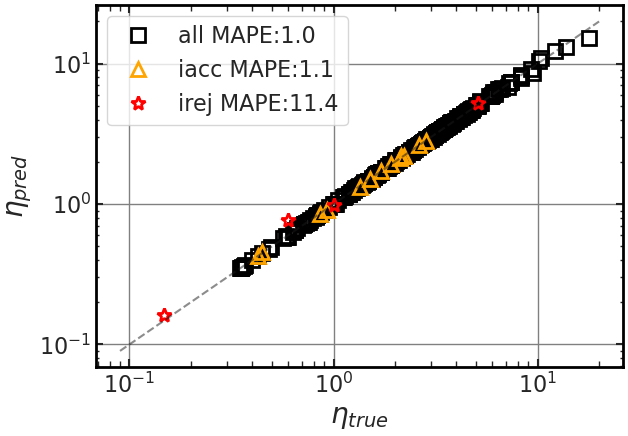

In [50]:
f,ax = plt.subplots(1,1,figsize=(6.8,4.8),dpi=100)

stline = np.arange(0.09,20,0.01)

ax.plot(Y_fset1_raw,ANN_ens_postMD_Vlugt_Ypred_stats_t1.yp_mean_arr,
        "s",c="black",mfc="none",label="all MAPE:{:.1f}".format(ANN_ens_postMD_Vlugt_mape))
ax.plot(Y_interp_accept_raw,ANN_ens_postMD_iacc_Ypred_stats_t1.yp_mean_arr,
        "^",c="orange",mfc="none",label="iacc MAPE:{:.1f}".format(ANN_ens_postMD_iacc_mape))
ax.plot(Y_interp_reject_raw,ANN_ens_postMD_irej_Ypred_stats_t1.yp_mean_arr,
        "*",c="red",mfc="none",label="irej MAPE:{:.1f}".format(ANN_ens_postMD_irej_mape))
ax.plot(stline,stline,"k--",alpha=0.5)

ax.legend()
ax.set_xscale("log") ; ax.set_yscale("log")
ax.set_xlabel(r"$\eta_{true}$") ; ax.set_ylabel(r"$\eta_{pred}$")
plt.savefig("figures/fig-ytrue-vs-ENSpred.png",dpi=300,bbox_inches='tight')

## Estimate the errors

In [51]:
# print(ANN_kfs_postMD_t1.Y_pred_interp_dbllist[0][0])
print(ANN_kfs_postMD_t1.Y_pred_interp_dbllist[0][0].shape)
print(ANN_kfs_postMD_t1.Y_pred_interp_dbllist[0][0][:,0])

[[0.7093986 ]
 [0.4483408 ]
 [2.1587398 ]
 [2.6683028 ]
 [0.8459195 ]
 [1.71861   ]
 [2.1995077 ]
 [1.3441877 ]
 [0.12895203]
 [0.91439325]
 [1.9452028 ]
 [2.1978846 ]
 [0.42600474]
 [5.2530146 ]
 [0.9538493 ]
 [2.835329  ]
 [1.5069566 ]]
(17, 1)
[0.7093986  0.4483408  2.1587398  2.6683028  0.8459195  1.71861
 2.1995077  1.3441877  0.12895203 0.91439325 1.9452028  2.1978846
 0.42600474 5.2530146  0.9538493  2.835329   1.5069566 ]


### Vlugt data

In [53]:
ANN_postMD_Vlugt_eval_t1  = evaluate_mymodel(Y_fset1_raw,ANN_ens_postMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
ANN_postMD_Vlugt_eval_t1.summary_tofile("ensemble-metrics/ANN_postMD_Vlugt_metrics-11aug22.csv")
ANN_postMD_Vlugt_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               4.64E-02    
    MEDIAN            0.01    
    2.5%              0.00    
    97.5%             0.30    
    MAX               2.72    
  MSE               3.54E-02    
  RMSE              1.88E-01    
  R2                0.992761   

  MAPE                0.97    
    MEDIAN            0.63    
    2.5%              0.04    
    97.5%             3.31    
    MAX              15.18    

  ME                 -0.01    
  MPE                -0.10    
    MEDIAN           -0.09    
    2.5%             -2.55    
    97.5%             2.50    
    MAX               5.85    
--------------------------------------------------------------


### All interpolation data

In [54]:
ANN_postMD_iall_eval_t1  = evaluate_mymodel(Y_interp_raw,ANN_ens_postMD_iall_Ypred_stats_t1.yp_mean_arr)
ANN_postMD_iall_eval_t1.summary_tofile("ensemble-metrics/ANN_postMD_iall_metrics-11aug22.csv")
ANN_postMD_iall_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               3.41E-02    
    MEDIAN            0.02    
    2.5%              0.00    
    97.5%             0.16    
    MAX               0.18    
  MSE               3.45E-03    
  RMSE              5.88E-02    
  R2                0.997473   

  MAPE                3.52    
    MEDIAN            1.28    
    2.5%              0.22    
    97.5%            22.00    
    MAX              29.48    

  ME                  0.02    
  MPE                 2.45    
    MEDIAN           -0.18    
    2.5%             -2.22    
    97.5%            22.00    
    MAX              29.48    
--------------------------------------------------------------


### Accepted interpolation data

In [55]:
ANN_postMD_iacc_eval_t1  = evaluate_mymodel(Y_interp_accept_raw,ANN_ens_postMD_iacc_Ypred_stats_t1.yp_mean_arr)
ANN_postMD_iacc_eval_t1.summary_tofile("ensemble-metrics/ANN_postMD_iacc_metrics-11aug22.csv")
ANN_postMD_iacc_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               1.66E-02    
    MEDIAN            0.01    
    2.5%              0.00    
    97.5%             0.05    
    MAX               0.05    
  MSE               4.64E-04    
  RMSE              2.16E-02    
  R2                0.999190   

  MAPE                1.08    
    MEDIAN            0.83    
    2.5%              0.19    
    97.5%             2.67    
    MAX               2.84    

  ME                  0.00    
  MPE                 0.11    
    MEDIAN           -0.25    
    2.5%             -1.40    
    97.5%             2.67    
    MAX               2.84    
--------------------------------------------------------------


### Rejected interpolation data

In [56]:
ANN_postMD_irej_eval_t1  = evaluate_mymodel(Y_interp_reject_raw,ANN_ens_postMD_irej_Ypred_stats_t1.yp_mean_arr)
ANN_postMD_irej_eval_t1.summary_tofile("ensemble-metrics/ANN_postMD_irej_metrics-11aug22.csv")
ANN_postMD_irej_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               9.02E-02    
    MEDIAN            0.08    
    2.5%              0.02    
    97.5%             0.17    
    MAX               0.18    
  MSE               1.30E-02    
  RMSE              1.14E-01    
  R2                0.996704   

  MAPE               11.45    
    MEDIAN            6.78    
    2.5%              2.76    
    97.5%            28.09    
    MAX              29.49    

  ME                  0.08    
  MPE                10.07    
    MEDIAN            6.77    
    2.5%             -2.35    
    97.5%            28.09    
    MAX              29.49    
--------------------------------------------------------------


## Manuscript plots

### All metrics

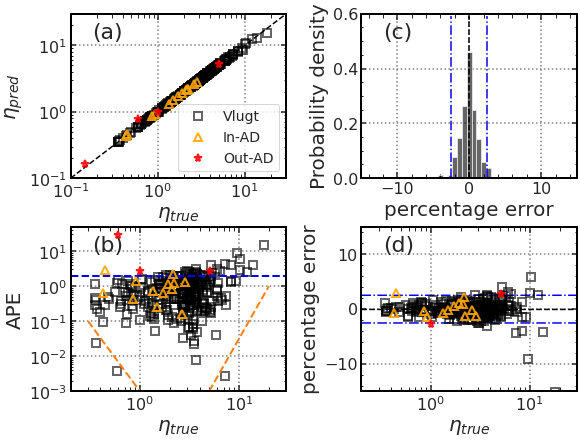

In [57]:
## Load the stylesheet
plt.style.use("../mpl-templates/sifig1.mplstyle")

## Set up some essentials
myaplha=0.6 ; myaplha2 = 0.9
testdata_relerr_mean = 2.0

sf1, sax1 = plt.subplots(nrows=2, ncols=2,
                       sharey=False, sharex=False, gridspec_kw= {"wspace" : 0.05},
                       constrained_layout=True, figsize=(8,6))


## pred visc vs true visc
xlow1, ylow1 = 0.1, 0.1
xhigh1, yhigh1 = 30, 30

stline = np.arange(xlow1,xhigh1,0.01)

sax1[0,0].plot(stline, stline, '--', c='black')
sax1[0,0].plot(ANN_postMD_Vlugt_eval_t1.Y_true, ANN_postMD_Vlugt_eval_t1.Y_pred,
            marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
            label="Vlugt", zorder=2)
sax1[0,0].plot(ANN_postMD_iacc_eval_t1.Y_true, ANN_postMD_iacc_eval_t1.Y_pred, 
            marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
            label="In-AD", zorder=4)
sax1[0,0].plot(ANN_postMD_irej_eval_t1.Y_true, ANN_postMD_irej_eval_t1.Y_pred, 
            marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
            label="Out-AD", zorder=4)


sax1[0,0].set_xlim(xlow1,xhigh1)
sax1[0,0].set_ylim(ylow1,yhigh1)
sax1[0,0].set_xscale("log")
sax1[0,0].set_yscale("log")

sax1[0,0].set_xlabel(r"$\eta_{true}$")
sax1[0,0].set_ylabel(r"$\eta_{pred}$")

sax1[0,0].legend(loc='lower right',fontsize=14)
sax1[0,0].grid(ls=":",lw=1.5)

## APE vs true visc
xlow1, ylow1 = 0.2, 0.001
xhigh1, yhigh1 = 30, 50
    
stline = np.arange(xlow1,xhigh1,0.01)

glinex1 = np.logspace(np.log10(0.3),np.log10(1),num=10,base=10)
gliney1 = np.logspace(-1,-3,num=10,base=10)
glinex2 = np.logspace(np.log10(5),np.log10(20),num=10,base=10)
gliney2 = np.logspace(-3,0,num=10,base=10)

sax1[1,0].plot(ANN_postMD_Vlugt_eval_t1.Y_true, ANN_postMD_Vlugt_eval_t1.metric_dict['resid_abs_percent'], 
              marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
              label="Train", zorder=2)

sax1[1,0].plot(ANN_postMD_iacc_eval_t1.Y_true, ANN_postMD_iacc_eval_t1.metric_dict['resid_abs_percent'],
              marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
              label="In-AD", zorder=4)

sax1[1,0].plot(ANN_postMD_irej_eval_t1.Y_true, ANN_postMD_irej_eval_t1.metric_dict['resid_abs_percent'],
              marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
              label="Out-AD", zorder=4)

sax1[1,0].axhline(y=testdata_relerr_mean, ls="--", lw=2.0, color="blue")
sax1[1,0].plot(glinex1, gliney1,'--',color="tab:orange", lw=2)
sax1[1,0].plot(glinex2, gliney2,'--',color="tab:orange", lw=2)


sax1[1,0].set_xlim(xlow1,xhigh1)
sax1[1,0].set_ylim(ylow1,yhigh1)
sax1[1,0].set_xscale("log")
sax1[1,0].set_yscale("log")

sax1[1,0].set_xlabel(r"$\eta_{true}$")
sax1[1,0].set_ylabel(r"APE")

# sax1[1,0].legend(loc='lower right')
sax1[1,0].grid(ls=":",lw=1.5)


## PE histogram
xlow1, ylow1 = -15, 0
xhigh1, yhigh1 = 15, 0.6
stline = np.arange(ylow1,yhigh1,0.01)

sax1[0,1].plot(0.0*stline + ANN_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , stline, 
         '--', c='black') 
sax1[0,1].plot(0.0*stline + ANN_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] , stline, 
         '-.', c='blue') 
sax1[0,1].plot(0.0*stline + ANN_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] , stline, 
         '-.', c='blue') 

sax1[0,1].hist(ANN_postMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         range=(-25,25), bins=75, density=True,
         rwidth=1 , color='black',alpha=0.6 ,label='Vlugt')

sax1[0,1].set_xlim(xlow1,xhigh1)
sax1[0,1].set_ylim(ylow1,yhigh1)

sax1[0,1].set_xlabel("percentage error")
sax1[0,1].set_ylabel("Probability density")

# sax1[0,1].legend()
sax1[0,1].grid(ls=":",lw=1.5)

    
## Residual % vs true visc
xlow1, ylow1 = 0.2, -15
xhigh1, yhigh1 = 30, 15
stline = np.arange(xlow1,xhigh1,0.01)
i=0
sax1[1,1].plot(stline, 0.0*stline + ANN_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , 
         '--', c='black') 
sax1[1,1].plot(stline, 0.0*stline + ANN_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] ,
         '-.', c='blue') 
sax1[1,1].plot(stline, 0.0*stline + ANN_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] ,
         '-.', c='blue') 

sax1[1,1].plot(ANN_postMD_Vlugt_eval_t1.Y_true, ANN_postMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         marker= 's', mec='black', ms=8, alpha=myaplha,
         label="Vlugt")

sax1[1,1].plot(ANN_postMD_iacc_eval_t1.Y_true, ANN_postMD_iacc_eval_t1.metric_dict['resid_percent'],
         marker= '^', mec='orange', ms=8, alpha=myaplha2,
         label="In-AD")

sax1[1,1].plot(ANN_postMD_irej_eval_t1.Y_true, ANN_postMD_irej_eval_t1.metric_dict['resid_percent'],
         marker= '*', mec='red', ms=8, alpha=myaplha2,
         label="Out-AD")

sax1[1,1].set_xlim(xlow1,xhigh1)
sax1[1,1].set_ylim(ylow1,yhigh1)
sax1[1,1].set_xscale("log")

sax1[1,1].set_xlabel(r"$\eta_{true}$")
sax1[1,1].set_ylabel(r"percentage error")

# sax1[1,1].legend(loc='upper center')
sax1[1,1].grid(ls=":",lw=1.5)

## Text Labels
sax1[0,0].text(0.1, 0.85,"(a)",transform=sax1[0,0].transAxes,fontsize=22)
sax1[1,0].text(0.1, 0.85,"(b)",transform=sax1[1,0].transAxes,fontsize=22)
sax1[0,1].text(0.1, 0.85,"(c)",transform=sax1[0,1].transAxes,fontsize=22)
sax1[1,1].text(0.1, 0.85,"(d)",transform=sax1[1,1].transAxes,fontsize=22)
    
## Save the figure to file
plt.savefig("figures/sifig-ANN-postMD-perf.png",dpi=300)

# Ensemble: preMD

## Predict the labels (eta) of the ensemble model: 
- Vlugt dataset 
- Interpolation set (all,acc,rej)

In [73]:
ft_indx = [0,1,2,3]
ANN_best_preMD_model_t1 = ANN_kfs_preMD_t1
ANN_ens_preMD_Vlugt_Ypred_list_t1 = []
ANN_ens_preMD_iall_Ypred_list_t1 = []
ANN_ens_preMD_iacc_Ypred_list_t1 = []
ANN_ens_preMD_irej_Ypred_list_t1 = []

for i in range(ANN_best_preMD_model_t1.num_splits):
    for j in range(ANN_best_preMD_model_t1.num_folds):
        this_model = ANN_best_preMD_model_t1.trained_model_dbllist[i][j]
        ## Vlugt data
        Ypred = np.power(10,this_model.predict(X_2000p_fset1_scaled[:,ft_indx]))
        ANN_ens_preMD_Vlugt_Ypred_list_t1.append(Ypred[:,0])
        
        ## All Interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_fset1_scaled[:,ft_indx]))
        ANN_ens_preMD_iall_Ypred_list_t1.append(Ypred[:,0])
        
        ## Accepted interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_accept_scaled[:,ft_indx]))
        ANN_ens_preMD_iacc_Ypred_list_t1.append(Ypred[:,0])
        
        ## Rejected interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_reject_scaled[:,ft_indx]))
        ANN_ens_preMD_irej_Ypred_list_t1.append(Ypred[:,0])

In [74]:
ANN_ens_preMD_Vlugt_Ypred_stats_t1 = stats_ypred(ANN_ens_preMD_Vlugt_Ypred_list_t1)
ANN_ens_preMD_iall_Ypred_stats_t1 = stats_ypred(ANN_ens_preMD_iall_Ypred_list_t1)
ANN_ens_preMD_iacc_Ypred_stats_t1 = stats_ypred(ANN_ens_preMD_iacc_Ypred_list_t1)
ANN_ens_preMD_irej_Ypred_stats_t1 = stats_ypred(ANN_ens_preMD_irej_Ypred_list_t1)

In [75]:
ANN_ens_preMD_Vlugt_mape = 100*mean_absolute_percentage_error(Y_fset1_raw,ANN_ens_preMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
ANN_ens_preMD_iall_mape = 100*mean_absolute_percentage_error(Y_interp_raw,ANN_ens_preMD_iall_Ypred_stats_t1.yp_mean_arr)
ANN_ens_preMD_iacc_mape = 100*mean_absolute_percentage_error(Y_interp_accept_raw,ANN_ens_preMD_iacc_Ypred_stats_t1.yp_mean_arr)
ANN_ens_preMD_irej_mape = 100*mean_absolute_percentage_error(Y_interp_reject_raw,ANN_ens_preMD_irej_Ypred_stats_t1.yp_mean_arr)

## Plot the results

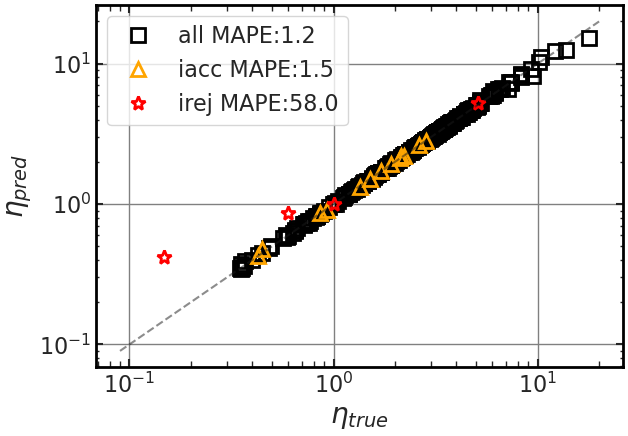

In [76]:
f,ax = plt.subplots(1,1,figsize=(6.8,4.8),dpi=100)

stline = np.arange(0.09,20,0.01)

ax.plot(Y_fset1_raw,ANN_ens_preMD_Vlugt_Ypred_stats_t1.yp_mean_arr,
        "s",c="black",mfc="none",label="all MAPE:{:.1f}".format(ANN_ens_preMD_Vlugt_mape))
ax.plot(Y_interp_accept_raw,ANN_ens_preMD_iacc_Ypred_stats_t1.yp_mean_arr,
        "^",c="orange",mfc="none",label="iacc MAPE:{:.1f}".format(ANN_ens_preMD_iacc_mape))
ax.plot(Y_interp_reject_raw,ANN_ens_preMD_irej_Ypred_stats_t1.yp_mean_arr,
        "*",c="red",mfc="none",label="irej MAPE:{:.1f}".format(ANN_ens_preMD_irej_mape))
ax.plot(stline,stline,"k--",alpha=0.5)

ax.legend()
ax.set_xscale("log") ; ax.set_yscale("log")
ax.set_xlabel(r"$\eta_{true}$") ; ax.set_ylabel(r"$\eta_{pred}$")
plt.savefig("figures/fig-preMD-ytrue-vs-ENSpred.png",dpi=300,bbox_inches='tight')

## Estimate the errors

In [77]:
# print(ANN_kfs_preMD_t1.Y_pred_interp_dbllist[0][0])
print(ANN_kfs_preMD_t1.Y_pred_interp_dbllist[0][0].shape)
print(ANN_kfs_preMD_t1.Y_pred_interp_dbllist[0][0][:,0])

(17, 1)
[0.8776064  0.47558558 2.090097   2.6175704  0.8424572  1.7004766
 2.1513429  1.3091562  0.41203785 0.90902257 1.897143   2.1637204
 0.42696404 5.3030643  0.98851365 2.8393524  1.4951935 ]


### Vlugt data

In [78]:
ANN_preMD_Vlugt_eval_t1  = evaluate_mymodel(Y_fset1_raw,ANN_ens_preMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
ANN_preMD_Vlugt_eval_t1.summary_tofile("ensemble-metrics/ANN_preMD_Vlugt_metrics-16aug22.csv")
ANN_preMD_Vlugt_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               5.34E-02    
    MEDIAN            0.02    
    2.5%              0.00    
    97.5%             0.27    
    MAX               2.67    
  MSE               4.29E-02    
  RMSE              2.07E-01    
  R2                0.991214   

  MAPE                1.15    
    MEDIAN            0.73    
    2.5%              0.06    
    97.5%             5.83    
    MAX              14.88    

  ME                 -0.01    
  MPE                 0.06    
    MEDIAN            0.14    
    2.5%             -2.49    
    97.5%             2.72    
    MAX               7.39    
--------------------------------------------------------------


### All interpolation data

In [79]:
ANN_preMD_iall_eval_t1  = evaluate_mymodel(Y_interp_raw,ANN_ens_preMD_iall_Ypred_stats_t1.yp_mean_arr)
ANN_preMD_iall_eval_t1.summary_tofile("ensemble-metrics/ANN_preMD_iall_metrics-16aug22.csv")
ANN_preMD_iall_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               5.45E-02    
    MEDIAN            0.02    
    2.5%              0.00    
    97.5%             0.27    
    MAX               0.27    
  MSE               1.05E-02    
  RMSE              1.02E-01    
  R2                0.992331   

  MAPE               14.77    
    MEDIAN            0.89    
    2.5%              0.08    
    97.5%           128.09    
    MAX             183.88    

  ME                  0.05    
  MPE                14.13    
    MEDIAN            0.52    
    2.5%             -1.63    
    97.5%           128.09    
    MAX             183.88    
--------------------------------------------------------------


### Accepted interpolation data

In [80]:
ANN_preMD_iacc_eval_t1  = evaluate_mymodel(Y_interp_accept_raw,ANN_ens_preMD_iacc_Ypred_stats_t1.yp_mean_arr)
ANN_preMD_iacc_eval_t1.summary_tofile("ensemble-metrics/ANN_preMD_iacc_metrics-16aug22.csv")
ANN_preMD_iacc_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               1.69E-02    
    MEDIAN            0.02    
    2.5%              0.00    
    97.5%             0.05    
    MAX               0.05    
  MSE               4.97E-04    
  RMSE              2.23E-02    
  R2                0.999133   

  MAPE                1.47    
    MEDIAN            0.70    
    2.5%              0.07    
    97.5%             6.61    
    MAX               8.37    

  ME                  0.01    
  MPE                 0.69    
    MEDIAN            0.18    
    2.5%             -1.73    
    97.5%             6.61    
    MAX               8.37    
--------------------------------------------------------------


### Rejected interpolation data

In [81]:
ANN_preMD_irej_eval_t1  = evaluate_mymodel(Y_interp_reject_raw,ANN_ens_preMD_irej_Ypred_stats_t1.yp_mean_arr)
ANN_preMD_irej_eval_t1.summary_tofile("ensemble-metrics/ANN_preMD_irej_metrics-16aug22.csv")
ANN_preMD_irej_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               1.77E-01    
    MEDIAN            0.22    
    2.5%              0.02    
    97.5%             0.27    
    MAX               0.27    
  MSE               4.31E-02    
  RMSE              2.08E-01    
  R2                0.989067   

  MAPE               58.01    
    MEDIAN           23.84    
    2.5%              0.65    
    97.5%           173.44    
    MAX             183.91    

  ME                  0.18    
  MPE                57.79    
    MEDIAN           23.84    
    2.5%             -0.16    
    97.5%           173.44    
    MAX             183.91    
--------------------------------------------------------------


## Manuscript plots

### All metrics

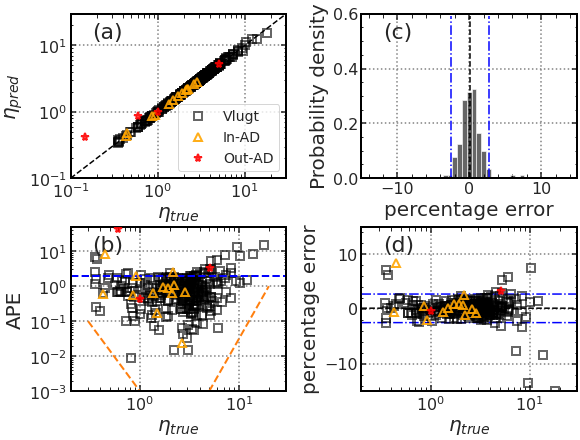

In [82]:
## Load the stylesheet
plt.style.use("../mpl-templates/sifig1.mplstyle")

## Set up some essentials
myaplha=0.6 ; myaplha2 = 0.9
testdata_relerr_mean = 2.0

sf1, sax1 = plt.subplots(nrows=2, ncols=2,
                       sharey=False, sharex=False, gridspec_kw= {"wspace" : 0.05},
                       constrained_layout=True, figsize=(8,6))


## pred visc vs true visc
xlow1, ylow1 = 0.1, 0.1
xhigh1, yhigh1 = 30, 30

stline = np.arange(xlow1,xhigh1,0.01)

sax1[0,0].plot(stline, stline, '--', c='black')
sax1[0,0].plot(ANN_preMD_Vlugt_eval_t1.Y_true, ANN_preMD_Vlugt_eval_t1.Y_pred,
            marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
            label="Vlugt", zorder=2)
sax1[0,0].plot(ANN_preMD_iacc_eval_t1.Y_true, ANN_preMD_iacc_eval_t1.Y_pred, 
            marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
            label="In-AD", zorder=4)
sax1[0,0].plot(ANN_preMD_irej_eval_t1.Y_true, ANN_preMD_irej_eval_t1.Y_pred, 
            marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
            label="Out-AD", zorder=4)


sax1[0,0].set_xlim(xlow1,xhigh1)
sax1[0,0].set_ylim(ylow1,yhigh1)
sax1[0,0].set_xscale("log")
sax1[0,0].set_yscale("log")

sax1[0,0].set_xlabel(r"$\eta_{true}$")
sax1[0,0].set_ylabel(r"$\eta_{pred}$")

sax1[0,0].legend(loc='lower right',fontsize=14)
sax1[0,0].grid(ls=":",lw=1.5)

## APE vs true visc
xlow1, ylow1 = 0.2, 0.001
xhigh1, yhigh1 = 30, 50
    
stline = np.arange(xlow1,xhigh1,0.01)

glinex1 = np.logspace(np.log10(0.3),np.log10(1),num=10,base=10)
gliney1 = np.logspace(-1,-3,num=10,base=10)
glinex2 = np.logspace(np.log10(5),np.log10(20),num=10,base=10)
gliney2 = np.logspace(-3,0,num=10,base=10)

sax1[1,0].plot(ANN_preMD_Vlugt_eval_t1.Y_true, ANN_preMD_Vlugt_eval_t1.metric_dict['resid_abs_percent'], 
              marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
              label="Train", zorder=2)

sax1[1,0].plot(ANN_preMD_iacc_eval_t1.Y_true, ANN_preMD_iacc_eval_t1.metric_dict['resid_abs_percent'],
              marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
              label="In-AD", zorder=4)

sax1[1,0].plot(ANN_preMD_irej_eval_t1.Y_true, ANN_preMD_irej_eval_t1.metric_dict['resid_abs_percent'],
              marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
              label="Out-AD", zorder=4)

sax1[1,0].axhline(y=testdata_relerr_mean, ls="--", lw=2.0, color="blue")
sax1[1,0].plot(glinex1, gliney1,'--',color="tab:orange", lw=2)
sax1[1,0].plot(glinex2, gliney2,'--',color="tab:orange", lw=2)


sax1[1,0].set_xlim(xlow1,xhigh1)
sax1[1,0].set_ylim(ylow1,yhigh1)
sax1[1,0].set_xscale("log")
sax1[1,0].set_yscale("log")

sax1[1,0].set_xlabel(r"$\eta_{true}$")
sax1[1,0].set_ylabel(r"APE")

# sax1[1,0].legend(loc='lower right')
sax1[1,0].grid(ls=":",lw=1.5)


## PE histogram
xlow1, ylow1 = -15, 0
xhigh1, yhigh1 = 15, 0.6
stline = np.arange(ylow1,yhigh1,0.01)

sax1[0,1].plot(0.0*stline + ANN_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , stline, 
         '--', c='black') 
sax1[0,1].plot(0.0*stline + ANN_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] , stline, 
         '-.', c='blue') 
sax1[0,1].plot(0.0*stline + ANN_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] , stline, 
         '-.', c='blue') 

sax1[0,1].hist(ANN_preMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         range=(-25,25), bins=75, density=True,
         rwidth=1 , color='black',alpha=0.6 ,label='Vlugt')

sax1[0,1].set_xlim(xlow1,xhigh1)
sax1[0,1].set_ylim(ylow1,yhigh1)

sax1[0,1].set_xlabel("percentage error")
sax1[0,1].set_ylabel("Probability density")

# sax1[0,1].legend()
sax1[0,1].grid(ls=":",lw=1.5)

    
## Residual % vs true visc
xlow1, ylow1 = 0.2, -15
xhigh1, yhigh1 = 30, 15
stline = np.arange(xlow1,xhigh1,0.01)
i=0
sax1[1,1].plot(stline, 0.0*stline + ANN_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , 
         '--', c='black') 
sax1[1,1].plot(stline, 0.0*stline + ANN_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] ,
         '-.', c='blue') 
sax1[1,1].plot(stline, 0.0*stline + ANN_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] ,
         '-.', c='blue') 

sax1[1,1].plot(ANN_preMD_Vlugt_eval_t1.Y_true, ANN_preMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         marker= 's', mec='black', ms=8, alpha=myaplha,
         label="Vlugt")

sax1[1,1].plot(ANN_preMD_iacc_eval_t1.Y_true, ANN_preMD_iacc_eval_t1.metric_dict['resid_percent'],
         marker= '^', mec='orange', ms=8, alpha=myaplha2,
         label="In-AD")

sax1[1,1].plot(ANN_preMD_irej_eval_t1.Y_true, ANN_preMD_irej_eval_t1.metric_dict['resid_percent'],
         marker= '*', mec='red', ms=8, alpha=myaplha2,
         label="Out-AD")

sax1[1,1].set_xlim(xlow1,xhigh1)
sax1[1,1].set_ylim(ylow1,yhigh1)
sax1[1,1].set_xscale("log")

sax1[1,1].set_xlabel(r"$\eta_{true}$")
sax1[1,1].set_ylabel(r"percentage error")

# sax1[1,1].legend(loc='upper center')
sax1[1,1].grid(ls=":",lw=1.5)

## Text Labels
sax1[0,0].text(0.1, 0.85,"(a)",transform=sax1[0,0].transAxes,fontsize=22)
sax1[1,0].text(0.1, 0.85,"(b)",transform=sax1[1,0].transAxes,fontsize=22)
sax1[0,1].text(0.1, 0.85,"(c)",transform=sax1[0,1].transAxes,fontsize=22)
sax1[1,1].text(0.1, 0.85,"(d)",transform=sax1[1,1].transAxes,fontsize=22)
    
## Save the figure to file
plt.savefig("figures/sifig-ANN-preMD-perf.png",dpi=300)

# Model interpolation
- x1_int
- sig2_int
- eps2_int
- k12_int

### preMD scaling

In [85]:
## transform the features if necessary
preMD_X_raw = X_2000p_fset1_raw[:,0:4]
preMD_sc = MinMaxScaler() ## Needs a 2D array -- if only a single feature, use reshape
preMD_sc.fit(preMD_X_raw) 
tmparr = preMD_sc.transform(preMD_X_raw)
print("X scaled : ", tmparr.shape)

X scaled :  (273, 4)


### Construct the interpolation grid

In [86]:
## Values used to construct the original X grid
x1_vals = [0.10, 0.30, 0.50, 0.70, 0.90] ; num_x1_vals = len(x1_vals)
eps2_vals = [0.50, 0.60, 0.80, 1.00] ; num_eps2_vals = len(eps2_vals)
sig2_vals = [1.0, 1.20, 1.40, 1.60] ; num_sig2_vals = len(sig2_vals)
k12_vals = [-0.60, -0.30, 0.00, 0.05] ; num_k12_vals = len(k12_vals)

In [87]:
## construct the total Vlugt grid
num_vlugt_grid_vals = num_x1_vals*num_eps2_vals*num_sig2_vals*num_k12_vals
print("Num of Vlugt grid points: ",num_vlugt_grid_vals)

vlugt_grid = np.zeros((num_vlugt_grid_vals,4))
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_eps2_vals):
        for k in range(num_sig2_vals):
            for l in range(num_k12_vals):
                vlugt_grid[cntr,:] = [x1_vals[i],eps2_vals[j],sig2_vals[k],k12_vals[l]]
                cntr += 1

## Get a scaled version
vlugt_grid_scaled = preMD_sc.transform(vlugt_grid)
# print("Raw grid   : ", vlugt_grid[0:2,:])
# print("Scaled grid: ", vlugt_grid_scaled[0:2,:])
print("Raw grid   : ", vlugt_grid.shape)
print("Scaled grid: ", vlugt_grid_scaled.shape)

## Locate holes
vlugt_holes = [] ; num_vlugt_holes = 0
for p in vlugt_grid:
    mindist = 2
    for d in preMD_X_raw:
        dist = np.linalg.norm(p-d)
        if (dist < mindist):
            mindist = dist
    if (mindist > 0.0001):
        vlugt_holes.append(p)
        num_vlugt_holes += 1
        
vlugt_holes = np.array(vlugt_holes)  
vlugt_holes_scaled = preMD_sc.transform(vlugt_holes)
print("Num holes  : ", num_vlugt_holes)
print("Vlugt holes: ", vlugt_holes.shape)
print("Vlugt holes: ", vlugt_holes[0:2,:])

# All data grid scales
preMD_X_raw_scaled = preMD_sc.transform(preMD_X_raw)

Num of Vlugt grid points:  320
Raw grid   :  (320, 4)
Scaled grid:  (320, 4)
Num holes  :  47
Vlugt holes:  (47, 4)
Vlugt holes:  [[0.1  0.5  1.   0.  ]
 [0.1  0.5  1.   0.05]]


In [88]:
## Create X_in -- a grid of values within X range by changing 1 feature at a time
num_in = 19 ; num_features = 4
print("Num of grid points: ",num_in)
print()

#### x1 interpolation ####
x1_int_vals = [] ; delx = x1_vals[num_x1_vals-1] - x1_vals[0] ; minx = x1_vals[0]
for i in range(1, num_in+1):
    x1_int_vals.append(minx + i*delx/(num_in+1.0))
print("x1 Grid values       : ",x1_int_vals)

num_x1_int_data = num_in*(num_eps2_vals*num_sig2_vals*num_k12_vals)
print("Num of interpolated points: ",num_x1_int_data)
assert num_x1_int_data < 100000 # a check to keep the program from crashing
x1_int = np.zeros((num_x1_int_data,num_features)) 
cntr = 0
for i in range(num_in):
    for j in range(num_eps2_vals):
        for k in range(num_sig2_vals):
            for l in range(num_k12_vals):
                tmp = np.array([x1_int_vals[i], eps2_vals[j], sig2_vals[k], k12_vals[l]])
                x1_int[cntr,:] = tmp.copy()
                cntr +=1
x1_int = preMD_sc.transform(x1_int)
print("x1 interpolate shape: ", x1_int.shape)
print()

#### eps2 interpolation ####
eps2_int_vals = [] ; delx = eps2_vals[num_eps2_vals-1] - eps2_vals[0] ; minx = eps2_vals[0]
for i in range(1, num_in+1):
    eps2_int_vals.append(minx + i*delx/(num_in+1.0))
print("eps2 Grid values       : ",eps2_int_vals)  

num_eps2_int_data = num_in*(num_x1_vals*num_sig2_vals*num_k12_vals)
print("Num of interpolated points: ",num_eps2_int_data)
assert num_eps2_int_data < 100000 # a check to keep the program from crashing
eps2_int = np.zeros((num_eps2_int_data,num_features)) 
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_in):
        for k in range(num_sig2_vals):
            for l in range(num_k12_vals):
                tmp = np.array([x1_vals[i], eps2_int_vals[j], sig2_vals[k], k12_vals[l]])
                eps2_int[cntr,:] = tmp.copy()
                cntr +=1
eps2_int = preMD_sc.transform(eps2_int)
print("eps2 interpolate shape: ", eps2_int.shape)
print()

#### sig2 interpolation ####
sig2_int_vals = [] ; delx = sig2_vals[num_sig2_vals-1] - sig2_vals[0] ; minx = sig2_vals[0]
for i in range(1, num_in+1):
    sig2_int_vals.append(minx + i*delx/(num_in+1.0))
print("sig2 Grid values       : ",sig2_int_vals)

num_sig2_int_data = num_in*(num_x1_vals*num_eps2_vals*num_k12_vals)
print("Num of interpolated points: ",num_sig2_int_data)
assert num_sig2_int_data < 100000 # a check to keep the program from crashing
sig2_int = np.zeros((num_sig2_int_data,num_features)) 
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_eps2_vals):
        for k in range(num_in):
            for l in range(num_k12_vals):
                tmp = np.array([x1_vals[i], eps2_vals[j], sig2_int_vals[k], k12_vals[l]])
                sig2_int[cntr,:] = tmp.copy()
                cntr +=1
sig2_int = preMD_sc.transform(sig2_int)
print("sig2 interpolate shape: ", sig2_int.shape)
print()

#### k12 interpolation ####
k12_int_vals = [] ; delx = k12_vals[num_k12_vals-1] - k12_vals[0] ; minx = k12_vals[0]
for i in range(1, num_in+1):
    k12_int_vals.append(minx + i*delx/(num_in+1.0))
print("k12 Grid values       : ",k12_int_vals) 

num_k12_int_data = num_in*(num_x1_vals*num_eps2_vals*num_sig2_vals)
print("Num of interpolated points: ",num_k12_int_data)
assert num_k12_int_data < 100000 # a check to keep the program from crashing
k12_int = np.zeros((num_k12_int_data,num_features)) 
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_eps2_vals):
        for k in range(num_sig2_vals):
            for l in range(num_in):
                tmp = np.array([x1_vals[i], eps2_vals[j], sig2_vals[k], k12_int_vals[l]])
                k12_int[cntr,:] = tmp.copy()
                cntr +=1
k12_int = preMD_sc.transform(k12_int)
print("k12 interpolate shape: ", k12_int.shape)
print()

Num of grid points:  19

x1 Grid values       :  [0.14, 0.18, 0.22000000000000003, 0.26, 0.30000000000000004, 0.3400000000000001, 0.38, 0.42000000000000004, 0.45999999999999996, 0.5, 0.54, 0.5800000000000001, 0.62, 0.66, 0.7, 0.74, 0.78, 0.82, 0.86]
Num of interpolated points:  1216
x1 interpolate shape:  (1216, 4)

eps2 Grid values       :  [0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
Num of interpolated points:  1520
eps2 interpolate shape:  (1520, 4)

sig2 Grid values       :  [1.03, 1.06, 1.09, 1.12, 1.15, 1.18, 1.21, 1.24, 1.27, 1.3, 1.33, 1.36, 1.3900000000000001, 1.4200000000000002, 1.4500000000000002, 1.48, 1.51, 1.54, 1.57]
Num of interpolated points:  1520
sig2 interpolate shape:  (1520, 4)

k12 Grid values       :  [-0.5675, -0.5349999999999999, -0.5025, -0.47, -0.4375, -0.40499999999999997, -0.3725, -0.33999999999999997, -0.30749999999999994, -0.27499999999999997, -0.24249999999999994, -0.2099999999

In [89]:
#### Color code the points w.r.t the distance from the nearest training point ####
# if  train_dist > vlugt_dist -> the point is closer to test than train set
# if  vlugt_dist > grid_dist  -> the point is closer to hole than train/test set

#### x1 interpolation distance ####
tic = time.perf_counter()
x1_train_dist = [] ; x1_vlugt_dist = [] ; x1_grid_dist = [] ; x1_hole_bool = []

indxlist = [1,2,3] ; cntr = 0
for x in x1_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    x1_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    x1_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    x1_grid_dist.append(mindist)

    if (x1_vlugt_dist[cntr] - x1_grid_dist[cntr] > 0.0001):
        x1_hole_bool.append(True)
    else:
        x1_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

#### eps2 interpolation distance ####
tic = time.perf_counter()
eps2_train_dist = [] ; eps2_vlugt_dist = [] ; eps2_grid_dist = [] ; eps2_hole_bool = []

indxlist = [0,2,3] ; cntr = 0
for x in eps2_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    eps2_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    eps2_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    eps2_grid_dist.append(mindist)

    if (eps2_vlugt_dist[cntr] - eps2_grid_dist[cntr] > 0.0001):
        eps2_hole_bool.append(True)
    else:
        eps2_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

#### sig2 interpolation distance ####
tic = time.perf_counter()
sig2_train_dist = [] ; sig2_vlugt_dist = [] ; sig2_grid_dist = [] ; sig2_hole_bool = []

indxlist = [0,1,3] ; cntr = 0
for x in sig2_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    sig2_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    sig2_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    sig2_grid_dist.append(mindist)

    if (sig2_vlugt_dist[cntr] - sig2_grid_dist[cntr] > 0.0001):
        sig2_hole_bool.append(True)
    else:
        sig2_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

#### k12 interpolation distance ####
tic = time.perf_counter()
k12_train_dist = [] ; k12_vlugt_dist = [] ; k12_grid_dist = [] ; k12_hole_bool = []

indxlist = [0,1,2] ; cntr = 0
for x in k12_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    k12_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    k12_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    k12_grid_dist.append(mindist)

    if (k12_vlugt_dist[cntr] - k12_grid_dist[cntr] > 0.0001):
        k12_hole_bool.append(True)
    else:
        k12_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

Time:  3.7310773079516366
Time:  4.734044268028811
Time:  4.760957446065731
Time:  4.778407815028913


In [90]:
tst = list(map(int, x1_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))
tst = list(map(int, eps2_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))
tst = list(map(int, sig2_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))
tst = list(map(int, k12_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))

Num int closer to holes :  205 1216 0.16858552631578946
Num int closer to holes :  137 1520 0.09013157894736842
Num int closer to holes :  216 1520 0.14210526315789473
Num int closer to holes :  134 1520 0.0881578947368421


### Evaluate the models at interpolated points

In [91]:
ft_indx = [0,1,2,3]
ANN_best_preMD_model_t1 = ANN_kfs_preMD_t1
ANN_ens_x1_int_Ypred_list_t1 = []
ANN_ens_sig2_int_Ypred_list_t1 = []
ANN_ens_eps2_int_Ypred_list_t1 = []
ANN_ens_k12_int_Ypred_list_t1 = []

for i in range(ANN_best_preMD_model_t1.num_splits):
    for j in range(ANN_best_preMD_model_t1.num_folds):
        this_model = ANN_best_preMD_model_t1.trained_model_dbllist[i][j]
        ## x1-int
        Ypred = np.power(10,this_model.predict(x1_int[:,ft_indx]))
        ANN_ens_x1_int_Ypred_list_t1.append(Ypred)
        
        ## sig2-int
        Ypred = np.power(10,this_model.predict(sig2_int[:,ft_indx]))
        ANN_ens_sig2_int_Ypred_list_t1.append(Ypred)
        
        ## eps2-int
        Ypred = np.power(10,this_model.predict(eps2_int[:,ft_indx]))
        ANN_ens_eps2_int_Ypred_list_t1.append(Ypred)
        
        ## k12-int
        Ypred = np.power(10,this_model.predict(k12_int[:,ft_indx]))
        ANN_ens_k12_int_Ypred_list_t1.append(Ypred)

In [92]:
ANN_ens_x1_int_Ypred_stats_t1 = stats_ypred(ANN_ens_x1_int_Ypred_list_t1)
ANN_ens_eps2_int_Ypred_stats_t1 = stats_ypred(ANN_ens_eps2_int_Ypred_list_t1)
ANN_ens_sig2_int_Ypred_stats_t1 = stats_ypred(ANN_ens_sig2_int_Ypred_list_t1)
ANN_ens_k12_int_Ypred_stats_t1 = stats_ypred(ANN_ens_k12_int_Ypred_list_t1)

## Figure 4 - Model interpolation

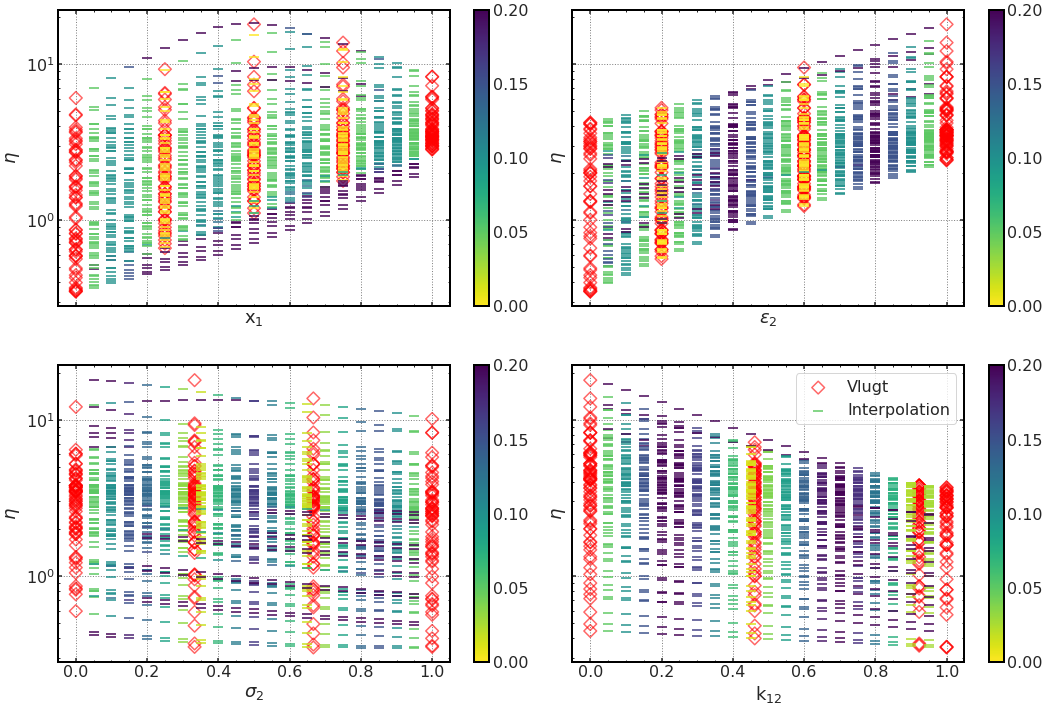

In [93]:
from matplotlib import cm
cmap1 = cm.get_cmap('viridis_r')
alpha1 = 1.0 ; alpha2 = 0.6

plt.style.use("../mpl-templates/interpolate.mplstyle")
mpl.rcParams['lines.markersize'] = 9
mpl.rcParams['lines.markerfacecolor'] = 'None'
mpl.rcParams['lines.markeredgecolor'] = 'black'
mpl.rcParams['lines.markeredgewidth'] = 0.5
mpl.rcParams['markers.fillstyle'] = 'none'
label_str = ['X_1', 'epsilon_2', 'sigma_2', 'k_12']

sf6, sax6 = plt.subplots(nrows=2, ncols=2, 
                       sharey=True, sharex=True, gridspec_kw= {"wspace" : 0.05},
                       figsize=(18,12))
cntr = 0
for i in range(2):
    for j in range(2):
        sax6[i,j].scatter(X_2000p_fset1_scaled[:,cntr], Y_fset1_raw,
                        marker="D", alpha=alpha2, c="red", label="Vlugt", linewidths=(1.5,))
        
        for spine in sax6[i,j].spines.values():
            spine.set_edgecolor('black')

        sax6[i,j].set_ylabel(r"$\eta$")
        sax6[i,j].set_yscale("log")
        sax6[i,j].grid(ls=":")
        cntr += 1 

#### x1 interpolation ####
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['markers.fillstyle'] = 'full'
sim1 = sax6[0,0].scatter(x1_int[:,0], ANN_ens_x1_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
                   c=x1_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
                   alpha=alpha1, 
                   label="Interpolation")

#### eps2 interpolation ####
sim2 = sax6[0,1].scatter(eps2_int[:,1], ANN_ens_eps2_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
           c=eps2_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
           alpha=alpha1, 
           label="Interpolation")

#### sig2 interpolation ####
sim3 = sax6[1,0].scatter(sig2_int[:,2], ANN_ens_sig2_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
           c=sig2_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
           alpha=alpha1, 
           label="Interpolation")

#### k12 interpolation ####
sim4 = sax6[1,1].scatter(k12_int[:,3], ANN_ens_k12_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
                 c=k12_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
                 alpha=alpha1, 
                 label="Interpolation")
ticklist = [0.0, 0.05, 0.10, 0.15, 0.20]
sf6.colorbar(sim1, ax=sax6[0,0],
             location = "right",
             ticks= ticklist, format='%.2f')
sf6.colorbar(sim2, ax=sax6[0,1],
             location = "right",
             ticks= ticklist, format='%.2f')
sf6.colorbar(sim3, ax=sax6[1,0],
             location = "right",
             ticks= ticklist, format='%.2f')
sf6.colorbar(sim4, ax=sax6[1,1],
             location = "right",
             ticks= ticklist, format='%.2f')

sax6[0,0].set_xlabel(r"X$_1$")
sax6[1,0].set_xlabel(r"$\sigma_2$")
sax6[0,1].set_xlabel(r"$\epsilon_2$")
sax6[1,1].set_xlabel(r"k$_{12}$")

plt.legend()
plt.savefig("figures/sfig-ANN-ens-interpolation.png",dpi=300)

# Save to files
- pickle.dump(obj, open(fname,'wb'))
- pickle.load(open(savepath+'test1.obj', 'rb'))

## Test saving the models

### save and load 

In [60]:
savepath = "best-models/"

## Save the models
saveobj = ANN_kfs_postMD_t1
pickle.dump(saveobj, open(savepath+'test1.obj', 'wb'))

## Save the metrics
saveobj = ANN_kfs_metrics_postMD_t1
pickle.dump(saveobj, open(savepath+'test2.obj', 'wb'))

2022-08-12 01:29:03.153539: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ea9d410c-3c90-41cd-8e90-f9df43eef7ee/assets
INFO:tensorflow:Assets written to: ram://bc5b80a6-7742-400d-8b9b-def3400796f8/assets
INFO:tensorflow:Assets written to: ram://1768ad52-02d6-4f16-8dfd-f9577631ff4b/assets
INFO:tensorflow:Assets written to: ram://cb2b9c9b-a752-4bc9-b5cd-f2b7a6994e7f/assets
INFO:tensorflow:Assets written to: ram://bf99cfd8-f55c-4855-9277-5e29b9713de9/assets
INFO:tensorflow:Assets written to: ram://dc457231-c1da-4da0-a1e5-d7634eb7be41/assets
INFO:tensorflow:Assets written to: ram://a4c16a49-d349-4526-80f7-d3d76dc28529/assets
INFO:tensorflow:Assets written to: ram://c934f727-9c1f-48bb-ba87-5bfd53cdc343/assets
INFO:tensorflow:Assets written to: ram://41ccef4d-b194-4047-8434-ccec6f3cee6b/assets
INFO:tensorflow:Assets written to: ram://781b2fff-e02d-483b-bea9-d833b4fd45cf/assets
INFO:tensorflow:Assets written to: ram://4bfd42c4-3503-4ff0-ab25-b556c0526097/assets
INFO:tensorflow:Assets written to: ram://63161114-bba7-4bc1-8463-

In [61]:
test1_loadobj = pickle.load(open(savepath+'test1.obj', 'rb'))
test2_loadobj = pickle.load(open(savepath+'test2.obj', 'rb'))

In [62]:
dir(test1_loadobj)

['Y_pred_interp_dbllist',
 'Y_pred_test_dbllist',
 'Y_pred_train_dbllist',
 'Y_pred_val_dbllist',
 'Yerr_pred_interp_dbllist',
 'Yerr_pred_test_dbllist',
 'Yerr_pred_train_dbllist',
 'Yerr_pred_val_dbllist',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'best_hyperparameter_dict',
 'fit_model_list',
 'ft_indx',
 'num_fit_pts',
 'num_folds',
 'num_interp_pts',
 'num_splits',
 'num_test_pts',
 'num_train_pts',
 'num_val_pts',
 'predict',
 'predict_for_performance_evaluation',
 'trained_model_dbllist']

### Test the loaded object

In [63]:
ft_indx = [0,1,2,3,4,5]
ANN_best_postMD_model_tl1 = test1_loadobj
ANN_ens_postMD_Vlugt_Ypred_list_tl1 = []
ANN_ens_postMD_iall_Ypred_list_tl1 = []
ANN_ens_postMD_iacc_Ypred_list_tl1 = []
ANN_ens_postMD_irej_Ypred_list_tl1 = []

for i in range(ANN_best_postMD_model_tl1.num_splits):
    for j in range(ANN_best_postMD_model_tl1.num_folds):
        this_model = ANN_best_postMD_model_tl1.trained_model_dbllist[i][j]
        ## Vlugt data
        Ypred = np.power(10,this_model.predict(X_2000p_fset1_scaled[:,ft_indx]))
        ANN_ens_postMD_Vlugt_Ypred_list_tl1.append(Ypred)
        
        ## All Interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_fset1_scaled[:,ft_indx]))
        ANN_ens_postMD_iall_Ypred_list_tl1.append(Ypred)
        
        ## Accepted interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_accept_scaled[:,ft_indx]))
        ANN_ens_postMD_iacc_Ypred_list_tl1.append(Ypred)
        
        ## Rejected interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_reject_scaled[:,ft_indx]))
        ANN_ens_postMD_irej_Ypred_list_tl1.append(Ypred)

ANN_ens_postMD_Vlugt_Ypred_stats_tl1 = stats_ypred(ANN_ens_postMD_Vlugt_Ypred_list_tl1)
ANN_ens_postMD_iall_Ypred_stats_tl1 = stats_ypred(ANN_ens_postMD_iall_Ypred_list_tl1)
ANN_ens_postMD_iacc_Ypred_stats_tl1 = stats_ypred(ANN_ens_postMD_iacc_Ypred_list_tl1)
ANN_ens_postMD_irej_Ypred_stats_tl1 = stats_ypred(ANN_ens_postMD_irej_Ypred_list_tl1)

ANN_ens_postMD_Vlugt_mape_tl1 = 100*mean_absolute_percentage_error(Y_fset1_raw,ANN_ens_postMD_Vlugt_Ypred_stats_tl1.yp_mean_arr)
ANN_ens_postMD_iall_mape_tl1 = 100*mean_absolute_percentage_error(Y_interp_raw,ANN_ens_postMD_iall_Ypred_stats_tl1.yp_mean_arr)
ANN_ens_postMD_iacc_mape_tl1 = 100*mean_absolute_percentage_error(Y_interp_accept_raw,ANN_ens_postMD_iacc_Ypred_stats_tl1.yp_mean_arr)
ANN_ens_postMD_irej_mape_tl1 = 100*mean_absolute_percentage_error(Y_interp_reject_raw,ANN_ens_postMD_irej_Ypred_stats_tl1.yp_mean_arr)


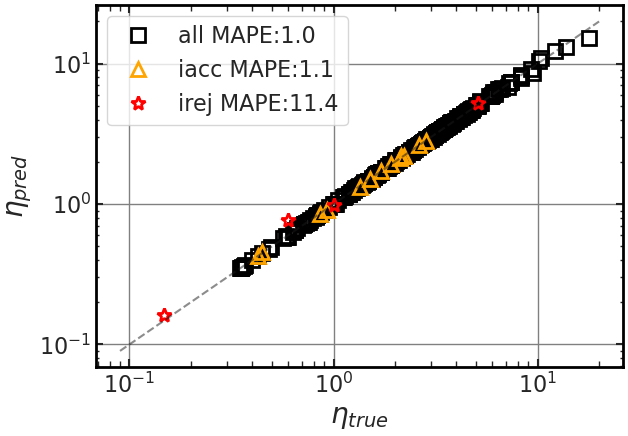

In [64]:
f,ax = plt.subplots(1,1,figsize=(6.8,4.8),dpi=100)

stline = np.arange(0.09,20,0.01)

ax.plot(Y_fset1_raw,ANN_ens_postMD_Vlugt_Ypred_stats_tl1.yp_mean_arr,
        "s",c="black",mfc="none",label="all MAPE:{:.1f}".format(ANN_ens_postMD_Vlugt_mape_tl1))
ax.plot(Y_interp_accept_raw,ANN_ens_postMD_iacc_Ypred_stats_tl1.yp_mean_arr,
        "^",c="orange",mfc="none",label="iacc MAPE:{:.1f}".format(ANN_ens_postMD_iacc_mape_tl1))
ax.plot(Y_interp_reject_raw,ANN_ens_postMD_irej_Ypred_stats_tl1.yp_mean_arr,
        "*",c="red",mfc="none",label="irej MAPE:{:.1f}".format(ANN_ens_postMD_irej_mape_tl1))
ax.plot(stline,stline,"k--",alpha=0.5)

ax.legend()
ax.set_xscale("log") ; ax.set_yscale("log")
ax.set_xlabel(r"$\eta_{true}$") ; ax.set_ylabel(r"$\eta_{pred}$")
plt.savefig("best-models/fig-ytrue-vs-ENSpred.png",dpi=300,bbox_inches='tight')

In [65]:
ANN_postMD_Vlugt_eval_tl1  = evaluate_mymodel(Y_fset1_raw,ANN_ens_postMD_Vlugt_Ypred_stats_tl1.yp_mean_arr)
ANN_postMD_Vlugt_eval_tl1.summary_tofile("best-models/ANN_postMD_Vlugt_metrics-11aug22.csv")
ANN_postMD_Vlugt_eval_tl1.summary()

--------------------------------------------------------------
  score             test                
  MAE               4.64E-02    
    MEDIAN            1.60    
    2.5%              0.06    
    97.5%             8.43    
    MAX              17.57    
  MSE               3.54E-02    
  RMSE              1.88E-01    
  R2                0.992761   

  MAPE                0.97    
    MEDIAN           58.60    
    2.5%              2.54    
    97.5%           715.78    
    MAX             4255.27    

  ME                 -0.01    
  MPE                71.75    
    MEDIAN           -0.05    
    2.5%            -87.82    
    97.5%           715.78    
    MAX             4255.27    
--------------------------------------------------------------


### Test the loaded metrics object

In [69]:
print(test2_loadobj.MSE_test_q2p5)
print(test2_loadobj.MSE_test_median)
print(test2_loadobj.MSE_test_avg)
print(test2_loadobj.MSE_test_q97p5)

0.006297002692719535
0.0600403057735321
0.09938741318213598
0.33119289450300865


## The best postMD models + metrics

In [67]:
savepath = "best-models/"

## Save the models
saveobj = ANN_kfs_postMD_t1
pickle.dump(saveobj, open(savepath+'ANN-best-postMD-models.obj', 'wb'))

## Save the metrics
saveobj = ANN_kfs_metrics_postMD_t1
pickle.dump(saveobj, open(savepath+'ANN-best-postMD-metrics.obj', 'wb'))

INFO:tensorflow:Assets written to: ram://b7db0904-8d94-4dd5-98c5-230dcc0fe7ab/assets
INFO:tensorflow:Assets written to: ram://1f7f1c40-11b6-4ef5-a350-fc07eb87f6e9/assets
INFO:tensorflow:Assets written to: ram://067220e7-37a3-49b4-8d9e-abdbc625cd57/assets
INFO:tensorflow:Assets written to: ram://b2e22834-17de-46de-b223-a38cac43aac2/assets
INFO:tensorflow:Assets written to: ram://f8e349aa-73df-4cd0-9109-75d88839bbf9/assets
INFO:tensorflow:Assets written to: ram://bcd2acd6-c7f3-482a-a62a-f9721190d71f/assets
INFO:tensorflow:Assets written to: ram://34cc551b-747e-4502-b3ef-6305d7cc4787/assets
INFO:tensorflow:Assets written to: ram://6d3b136a-8661-495d-8699-2da79de2a806/assets
INFO:tensorflow:Assets written to: ram://dc578f48-7a45-4aff-88de-4e7ff1980d90/assets
INFO:tensorflow:Assets written to: ram://e19e43fb-b2f8-48e6-bcba-52fb3a9b55c4/assets
INFO:tensorflow:Assets written to: ram://f8faba68-7d1f-4be6-85dc-1d867158082c/assets
INFO:tensorflow:Assets written to: ram://4d94669b-02e5-4862-835f-

## The best preMD models + metrics

In [83]:
savepath = "best-models/"

## Save the models
saveobj = ANN_kfs_preMD_t1
pickle.dump(saveobj, open(savepath+'ANN-best-preMD-models.obj', 'wb'))

## Save the metrics
saveobj = ANN_kfs_metrics_preMD_t1
pickle.dump(saveobj, open(savepath+'ANN-best-preMD-metrics.obj', 'wb'))

INFO:tensorflow:Assets written to: ram://2de38d9c-1c0f-4d9b-b953-221f441877de/assets
INFO:tensorflow:Assets written to: ram://a8bbcd8a-d33c-49b1-9128-4f6f327e8c83/assets
INFO:tensorflow:Assets written to: ram://141094ee-b93f-4a50-9dc0-fae26728dfbb/assets
INFO:tensorflow:Assets written to: ram://d3676fea-46ac-4104-aa7b-6f7c521915bc/assets
INFO:tensorflow:Assets written to: ram://adf934da-caeb-4981-b98f-6b834f51fa8a/assets
INFO:tensorflow:Assets written to: ram://4d376da8-d5b9-4daf-b517-e5680f777905/assets
INFO:tensorflow:Assets written to: ram://9d0f0f08-d901-4696-8ff6-df6d5a7bcbff/assets
INFO:tensorflow:Assets written to: ram://d9401520-ee4b-4880-ab26-207bd96f153f/assets
INFO:tensorflow:Assets written to: ram://84942a27-899a-45c0-9512-3a7ec4bc72ed/assets
INFO:tensorflow:Assets written to: ram://71380b52-e03e-40bd-94a5-9762e4bc8d48/assets
INFO:tensorflow:Assets written to: ram://22698193-c792-4fd8-9e4e-417bd6235a03/assets
INFO:tensorflow:Assets written to: ram://69beabdc-edab-4f12-a2ee-

## The ensemble results

### postMD results

In [68]:
## Save the models
saveobj = ANN_ens_postMD_Vlugt_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-postMD-Vlugt-ypred.obj', 'wb'))

saveobj = ANN_ens_postMD_iall_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-postMD-iall-ypred.obj', 'wb'))

saveobj = ANN_ens_postMD_iacc_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-postMD-iacc-ypred.obj', 'wb'))

saveobj = ANN_ens_postMD_irej_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-postMD-irej-ypred.obj', 'wb'))

### preMD results

In [84]:
## Save the models
saveobj = ANN_ens_preMD_Vlugt_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-preMD-Vlugt-ypred.obj', 'wb'))

saveobj = ANN_ens_preMD_iall_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-preMD-iall-ypred.obj', 'wb'))

saveobj = ANN_ens_preMD_iacc_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-preMD-iacc-ypred.obj', 'wb'))

saveobj = ANN_ens_preMD_irej_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-ens-preMD-irej-ypred.obj', 'wb'))

## The interpolation results

In [94]:
## Save the models
saveobj = ANN_ens_x1_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-interp-x1-ypred.obj', 'wb'))

saveobj = ANN_ens_eps2_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-interp-eps2-ypred.obj', 'wb'))

saveobj = ANN_ens_sig2_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-interp-sig2-ypred.obj', 'wb'))

saveobj = ANN_ens_k12_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'ANN-interp-k12-ypred.obj', 'wb'))